# HELPERS


In [0]:
# pytorch
import torch
import numpy as np
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from IPython.display import clear_output

def to_gpu(x):
  if torch.cuda.is_available():
    x = x.cuda()
  return x

# Training GANS


## GAN seen as a *minmax* game

![](https://drive.google.com/uc?export=view&id=1KVkTMjTT7jr8gfIv-1c4LRosrCZRpJd9)

## Training intuition

![](https://drive.google.com/uc?export=view&id=15G9ZuSZqLG-E8LufyT-UnN9V0lme3nJZ)

## Training procedure

![alt text](https://drive.google.com/uc?export=view&id=1_JMKgK48QbhU9W9F9DG6dPQpYZPcYGSE)


In [0]:
def gan_magic(generator, discriminator, data_loader, noise, plot, epochs=100,
              disc_steps=1, test_samples=10, draw_every_n=1, d_lr=0.001, g_lr=0.001):
  # Total number of epochs to train
  num_epochs = epochs

  test_noise = noise(test_samples)
  
  d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)
  g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)
  
  loss = nn.BCELoss()
  
  def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)

    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake
  
  def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error
  


  for epoch in range(num_epochs):
      for n_batch, (real_batch,_) in enumerate(data_loader):
          N = real_batch.size(0)
          
          real_data = to_gpu(Variable(real_batch))

          # 1. Train Discriminator
          # 1.1 Generate fake data and detach 
          # (so gradients are not calculated for generator)
          fake_data = generator(noise(N)).detach()
          # 1.2 Train D
          d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)
      
          # 2. Train Generator every "k = disc_steps" steps
          if n_batch % disc_steps == 0:        
            # 2.1 Generate fake data again
            fake_data = generator(noise(N))
            # 2.2 Train G
            g_error = train_generator(g_optimizer, fake_data)

      # Display samples every few batches
      if epoch % draw_every_n == 0: 
          test_images = generator(test_noise).cpu()
          test_images = test_images.data
          plot(test_images)
          
      # Display status Logs
      display_status(
          epoch, num_epochs,
          d_error, g_error, d_pred_real, d_pred_fake
      )
        
 

In [0]:
def display_status(epoch, num_epochs, d_error, g_error, d_pred_real, d_pred_fake):

    # var_class = torch.autograd.variable.Variable
    if isinstance(d_error, torch.autograd.Variable):
        d_error = d_error.data.cpu().numpy()
    if isinstance(g_error, torch.autograd.Variable):
        g_error = g_error.data.cpu().numpy()
    if isinstance(d_pred_real, torch.autograd.Variable):
        d_pred_real = d_pred_real.data
    if isinstance(d_pred_fake, torch.autograd.Variable):
        d_pred_fake = d_pred_fake.data


    print('Epoch: [{}/{}]'.format(epoch,num_epochs))
    print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
    print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))


In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return to_gpu(data)
def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return to_gpu(data)

# Vanilla GAN

In [0]:
LATENT_SIZE = 10
BATCH_SIZE = 32
TEST_SAMPLES = 16

def circle_noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.rand(size, LATENT_SIZE))
    return to_gpu(n)

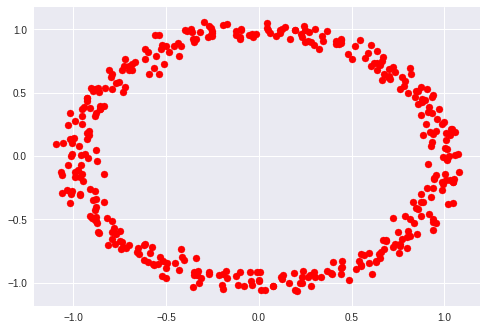

In [0]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import random

# generate 2d classification dataset
X, _ = make_circles(n_samples=400, noise=0.05, factor=0.99)

def plot_circle(data):
  xax = data[:,0]
  yax = data[:,1]

  plt.scatter(xax, yax, c='red')
  plt.show()

class CircleGenerator:
  def __init__(self, data):
    self.data = data
    
    
  def gen_batches(self):
    for _ in range(len(self.data) // BATCH_SIZE):
      dcopy = self.data.copy()
      np.random.shuffle(dcopy)
      yield torch.from_numpy(dcopy[:BATCH_SIZE].astype(np.float32)), None # second one just for compatibility

  def __iter__(self):
    return self.gen_batches()

  
circle_data_loader = CircleGenerator(X)

plot_circle(X)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 50),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(50, 20),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(20, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

discriminator = to_gpu(DiscriminatorNet())


class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 10
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 20),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(20, 50),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(50, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

generator = to_gpu(GeneratorNet())

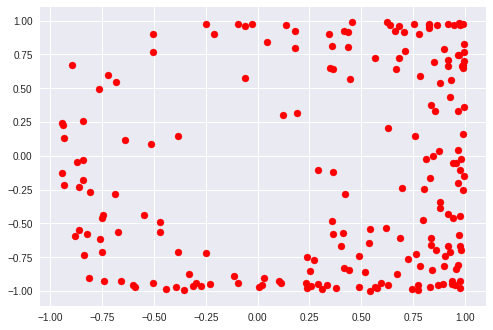

Epoch: [0/1000]
Discriminator Loss: 1.0101, Generator Loss: 0.9939
D(x): 0.6244, D(G(z)): 0.3621
Epoch: [1/1000]
Discriminator Loss: 1.3793, Generator Loss: 1.0274
D(x): 0.5270, D(G(z)): 0.4746
Epoch: [2/1000]
Discriminator Loss: 1.3873, Generator Loss: 1.0459
D(x): 0.5043, D(G(z)): 0.4012
Epoch: [3/1000]
Discriminator Loss: 1.1753, Generator Loss: 1.2868
D(x): 0.6259, D(G(z)): 0.4169
Epoch: [4/1000]
Discriminator Loss: 1.4062, Generator Loss: 0.7816
D(x): 0.5166, D(G(z)): 0.4708
Epoch: [5/1000]
Discriminator Loss: 1.1808, Generator Loss: 0.9808
D(x): 0.5721, D(G(z)): 0.4171
Epoch: [6/1000]
Discriminator Loss: 0.9209, Generator Loss: 1.2791
D(x): 0.6601, D(G(z)): 0.3506
Epoch: [7/1000]
Discriminator Loss: 1.1972, Generator Loss: 1.0373
D(x): 0.5740, D(G(z)): 0.3997
Epoch: [8/1000]
Discriminator Loss: 1.1227, Generator Loss: 0.9030
D(x): 0.5935, D(G(z)): 0.3842
Epoch: [9/1000]
Discriminator Loss: 1.2336, Generator Loss: 1.0065
D(x): 0.5877, D(G(z)): 0.4353


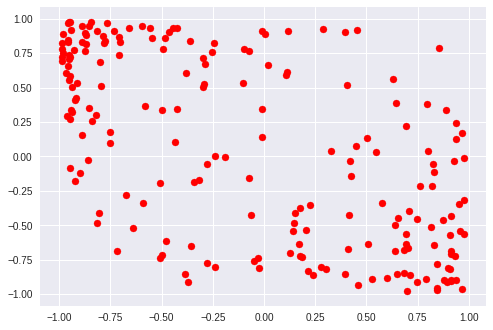

Epoch: [10/1000]
Discriminator Loss: 1.1600, Generator Loss: 1.0456
D(x): 0.6056, D(G(z)): 0.4145
Epoch: [11/1000]
Discriminator Loss: 1.2142, Generator Loss: 1.1877
D(x): 0.5522, D(G(z)): 0.4022
Epoch: [12/1000]
Discriminator Loss: 1.2062, Generator Loss: 1.1472
D(x): 0.5912, D(G(z)): 0.4222
Epoch: [13/1000]
Discriminator Loss: 1.2224, Generator Loss: 0.9590
D(x): 0.6274, D(G(z)): 0.4400
Epoch: [14/1000]
Discriminator Loss: 1.2924, Generator Loss: 0.9131
D(x): 0.5419, D(G(z)): 0.4213
Epoch: [15/1000]
Discriminator Loss: 1.0481, Generator Loss: 1.6885
D(x): 0.6341, D(G(z)): 0.3406
Epoch: [16/1000]
Discriminator Loss: 1.1659, Generator Loss: 0.9927
D(x): 0.6004, D(G(z)): 0.4128
Epoch: [17/1000]
Discriminator Loss: 1.1290, Generator Loss: 0.9193
D(x): 0.5868, D(G(z)): 0.3929
Epoch: [18/1000]
Discriminator Loss: 1.2922, Generator Loss: 0.9699
D(x): 0.5132, D(G(z)): 0.3946
Epoch: [19/1000]
Discriminator Loss: 1.1774, Generator Loss: 1.1089
D(x): 0.5889, D(G(z)): 0.3878


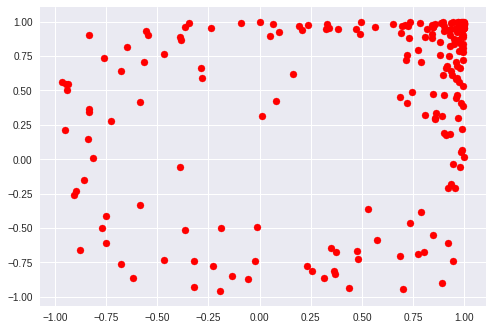

Epoch: [20/1000]
Discriminator Loss: 1.1613, Generator Loss: 1.6733
D(x): 0.6864, D(G(z)): 0.4132
Epoch: [21/1000]
Discriminator Loss: 1.3054, Generator Loss: 1.2238
D(x): 0.6362, D(G(z)): 0.4881
Epoch: [22/1000]
Discriminator Loss: 1.2311, Generator Loss: 0.7879
D(x): 0.5531, D(G(z)): 0.4401
Epoch: [23/1000]
Discriminator Loss: 1.1177, Generator Loss: 0.9888
D(x): 0.5391, D(G(z)): 0.3748
Epoch: [24/1000]
Discriminator Loss: 1.3077, Generator Loss: 0.6639
D(x): 0.5593, D(G(z)): 0.5002
Epoch: [25/1000]
Discriminator Loss: 1.0027, Generator Loss: 1.0402
D(x): 0.6536, D(G(z)): 0.3969
Epoch: [26/1000]
Discriminator Loss: 1.1437, Generator Loss: 1.1830
D(x): 0.5584, D(G(z)): 0.3462
Epoch: [27/1000]
Discriminator Loss: 0.9905, Generator Loss: 0.8631
D(x): 0.6917, D(G(z)): 0.4216
Epoch: [28/1000]
Discriminator Loss: 0.9569, Generator Loss: 1.0296
D(x): 0.6752, D(G(z)): 0.3796
Epoch: [29/1000]
Discriminator Loss: 1.1253, Generator Loss: 0.9496
D(x): 0.6042, D(G(z)): 0.3919


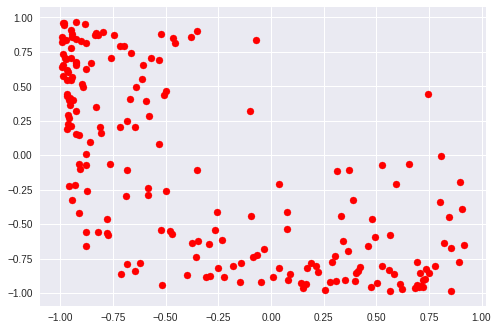

Epoch: [30/1000]
Discriminator Loss: 1.0515, Generator Loss: 1.0069
D(x): 0.6057, D(G(z)): 0.3640
Epoch: [31/1000]
Discriminator Loss: 1.1926, Generator Loss: 1.1860
D(x): 0.5497, D(G(z)): 0.3715
Epoch: [32/1000]
Discriminator Loss: 1.1178, Generator Loss: 1.2357
D(x): 0.6215, D(G(z)): 0.4086
Epoch: [33/1000]
Discriminator Loss: 1.0501, Generator Loss: 1.3435
D(x): 0.5722, D(G(z)): 0.3283
Epoch: [34/1000]
Discriminator Loss: 1.2347, Generator Loss: 1.4274
D(x): 0.6232, D(G(z)): 0.3910
Epoch: [35/1000]
Discriminator Loss: 1.1556, Generator Loss: 1.1524
D(x): 0.6424, D(G(z)): 0.3830
Epoch: [36/1000]
Discriminator Loss: 1.1879, Generator Loss: 0.9650
D(x): 0.6062, D(G(z)): 0.4228
Epoch: [37/1000]
Discriminator Loss: 1.4017, Generator Loss: 1.1414
D(x): 0.5064, D(G(z)): 0.4424
Epoch: [38/1000]
Discriminator Loss: 1.3501, Generator Loss: 0.6487
D(x): 0.5838, D(G(z)): 0.5320
Epoch: [39/1000]
Discriminator Loss: 1.3578, Generator Loss: 0.8022
D(x): 0.5022, D(G(z)): 0.4608


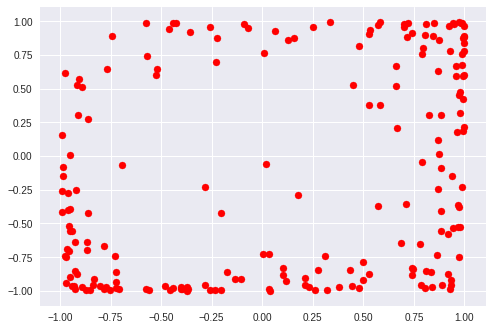

Epoch: [40/1000]
Discriminator Loss: 1.3612, Generator Loss: 0.7557
D(x): 0.5072, D(G(z)): 0.4656
Epoch: [41/1000]
Discriminator Loss: 1.1453, Generator Loss: 0.9191
D(x): 0.5822, D(G(z)): 0.4239
Epoch: [42/1000]
Discriminator Loss: 1.2525, Generator Loss: 0.9633
D(x): 0.5465, D(G(z)): 0.4310
Epoch: [43/1000]
Discriminator Loss: 1.3314, Generator Loss: 0.9373
D(x): 0.5831, D(G(z)): 0.5134
Epoch: [44/1000]
Discriminator Loss: 1.2036, Generator Loss: 0.9884
D(x): 0.5602, D(G(z)): 0.4247
Epoch: [45/1000]
Discriminator Loss: 1.2540, Generator Loss: 1.1331
D(x): 0.5282, D(G(z)): 0.4196
Epoch: [46/1000]
Discriminator Loss: 1.3191, Generator Loss: 1.0478
D(x): 0.5454, D(G(z)): 0.4702
Epoch: [47/1000]
Discriminator Loss: 1.3428, Generator Loss: 0.8532
D(x): 0.5415, D(G(z)): 0.4892
Epoch: [48/1000]
Discriminator Loss: 1.3581, Generator Loss: 0.9154
D(x): 0.5056, D(G(z)): 0.4294
Epoch: [49/1000]
Discriminator Loss: 1.3941, Generator Loss: 0.7435
D(x): 0.5410, D(G(z)): 0.5215


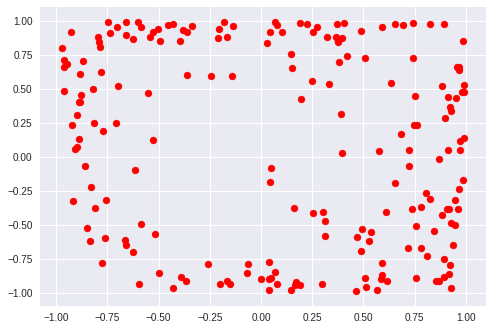

Epoch: [50/1000]
Discriminator Loss: 1.3103, Generator Loss: 0.7689
D(x): 0.5348, D(G(z)): 0.4777
Epoch: [51/1000]
Discriminator Loss: 1.2322, Generator Loss: 0.8815
D(x): 0.5453, D(G(z)): 0.4460
Epoch: [52/1000]
Discriminator Loss: 1.3022, Generator Loss: 0.8693
D(x): 0.5159, D(G(z)): 0.4487
Epoch: [53/1000]
Discriminator Loss: 1.3868, Generator Loss: 1.0131
D(x): 0.4934, D(G(z)): 0.4510
Epoch: [54/1000]
Discriminator Loss: 1.3217, Generator Loss: 0.9110
D(x): 0.5301, D(G(z)): 0.4429
Epoch: [55/1000]
Discriminator Loss: 1.2299, Generator Loss: 0.9067
D(x): 0.5683, D(G(z)): 0.4418
Epoch: [56/1000]
Discriminator Loss: 1.2497, Generator Loss: 0.8935
D(x): 0.5368, D(G(z)): 0.4087
Epoch: [57/1000]
Discriminator Loss: 1.3853, Generator Loss: 0.6770
D(x): 0.5516, D(G(z)): 0.5118
Epoch: [58/1000]
Discriminator Loss: 1.3668, Generator Loss: 0.7313
D(x): 0.5206, D(G(z)): 0.4923
Epoch: [59/1000]
Discriminator Loss: 1.3769, Generator Loss: 0.7974
D(x): 0.4946, D(G(z)): 0.4677


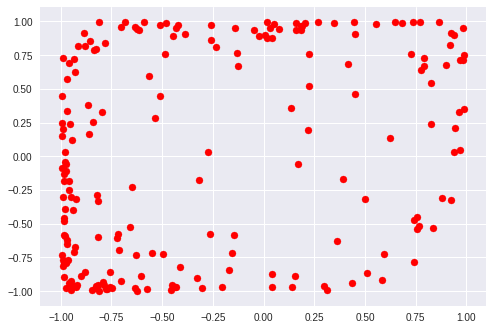

Epoch: [60/1000]
Discriminator Loss: 1.3226, Generator Loss: 0.8139
D(x): 0.5228, D(G(z)): 0.4678
Epoch: [61/1000]
Discriminator Loss: 1.3032, Generator Loss: 0.9345
D(x): 0.5380, D(G(z)): 0.4620
Epoch: [62/1000]
Discriminator Loss: 1.3220, Generator Loss: 0.8413
D(x): 0.5046, D(G(z)): 0.4284
Epoch: [63/1000]
Discriminator Loss: 1.3330, Generator Loss: 0.8636
D(x): 0.5399, D(G(z)): 0.4638
Epoch: [64/1000]
Discriminator Loss: 1.3206, Generator Loss: 0.9038
D(x): 0.5468, D(G(z)): 0.4793
Epoch: [65/1000]
Discriminator Loss: 1.2321, Generator Loss: 0.7424
D(x): 0.5463, D(G(z)): 0.4321
Epoch: [66/1000]
Discriminator Loss: 1.2706, Generator Loss: 0.9060
D(x): 0.5674, D(G(z)): 0.4725
Epoch: [67/1000]
Discriminator Loss: 1.3217, Generator Loss: 0.8040
D(x): 0.5333, D(G(z)): 0.4661
Epoch: [68/1000]
Discriminator Loss: 1.3062, Generator Loss: 0.7193
D(x): 0.5228, D(G(z)): 0.4522
Epoch: [69/1000]
Discriminator Loss: 1.3579, Generator Loss: 0.8026
D(x): 0.5012, D(G(z)): 0.4566


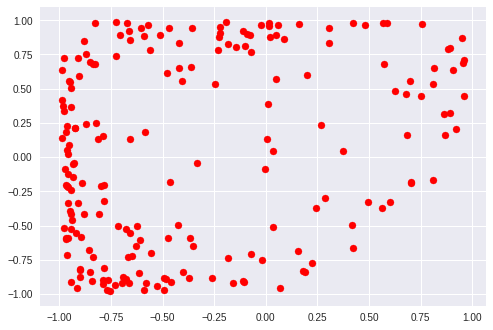

Epoch: [70/1000]
Discriminator Loss: 1.1401, Generator Loss: 0.9093
D(x): 0.5575, D(G(z)): 0.3823
Epoch: [71/1000]
Discriminator Loss: 1.3214, Generator Loss: 0.9319
D(x): 0.5444, D(G(z)): 0.4733
Epoch: [72/1000]
Discriminator Loss: 1.2170, Generator Loss: 0.9892
D(x): 0.5460, D(G(z)): 0.4250
Epoch: [73/1000]
Discriminator Loss: 1.0671, Generator Loss: 0.8741
D(x): 0.6182, D(G(z)): 0.3944
Epoch: [74/1000]
Discriminator Loss: 1.1968, Generator Loss: 1.0962
D(x): 0.5663, D(G(z)): 0.3788
Epoch: [75/1000]
Discriminator Loss: 1.2971, Generator Loss: 0.8575
D(x): 0.5655, D(G(z)): 0.4466
Epoch: [76/1000]
Discriminator Loss: 1.3692, Generator Loss: 0.9505
D(x): 0.5347, D(G(z)): 0.4126
Epoch: [77/1000]
Discriminator Loss: 1.4278, Generator Loss: 0.9652
D(x): 0.5228, D(G(z)): 0.4775
Epoch: [78/1000]
Discriminator Loss: 1.3389, Generator Loss: 0.8044
D(x): 0.5345, D(G(z)): 0.4703
Epoch: [79/1000]
Discriminator Loss: 1.4742, Generator Loss: 0.8142
D(x): 0.4763, D(G(z)): 0.4763


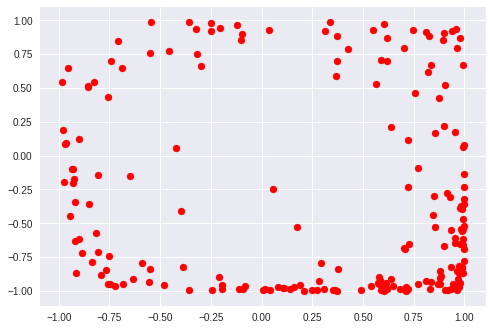

Epoch: [80/1000]
Discriminator Loss: 1.1984, Generator Loss: 1.3860
D(x): 0.5008, D(G(z)): 0.3444
Epoch: [81/1000]
Discriminator Loss: 1.1672, Generator Loss: 1.0934
D(x): 0.5915, D(G(z)): 0.4444
Epoch: [82/1000]
Discriminator Loss: 1.2751, Generator Loss: 0.8300
D(x): 0.5470, D(G(z)): 0.4521
Epoch: [83/1000]
Discriminator Loss: 1.1940, Generator Loss: 0.8336
D(x): 0.5493, D(G(z)): 0.4249
Epoch: [84/1000]
Discriminator Loss: 1.2613, Generator Loss: 1.1212
D(x): 0.5351, D(G(z)): 0.4263
Epoch: [85/1000]
Discriminator Loss: 1.3280, Generator Loss: 0.9423
D(x): 0.5886, D(G(z)): 0.4716
Epoch: [86/1000]
Discriminator Loss: 1.3050, Generator Loss: 0.8472
D(x): 0.5612, D(G(z)): 0.4743
Epoch: [87/1000]
Discriminator Loss: 1.2384, Generator Loss: 0.8746
D(x): 0.5551, D(G(z)): 0.4384
Epoch: [88/1000]
Discriminator Loss: 1.2125, Generator Loss: 1.0178
D(x): 0.5591, D(G(z)): 0.4282
Epoch: [89/1000]
Discriminator Loss: 1.3911, Generator Loss: 0.9843
D(x): 0.5219, D(G(z)): 0.4761


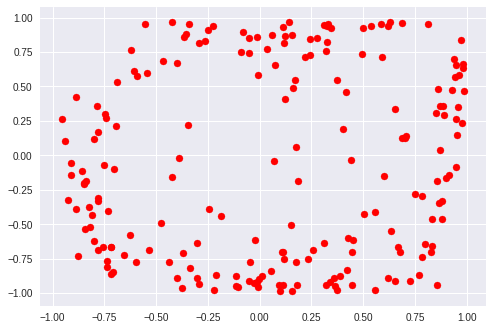

Epoch: [90/1000]
Discriminator Loss: 1.2446, Generator Loss: 0.9456
D(x): 0.5103, D(G(z)): 0.3904
Epoch: [91/1000]
Discriminator Loss: 1.3019, Generator Loss: 0.8747
D(x): 0.5945, D(G(z)): 0.5103
Epoch: [92/1000]
Discriminator Loss: 1.3990, Generator Loss: 0.8000
D(x): 0.4978, D(G(z)): 0.4489
Epoch: [93/1000]
Discriminator Loss: 1.4240, Generator Loss: 0.9544
D(x): 0.5032, D(G(z)): 0.4728
Epoch: [94/1000]
Discriminator Loss: 1.4474, Generator Loss: 0.7971
D(x): 0.5141, D(G(z)): 0.4973
Epoch: [95/1000]
Discriminator Loss: 1.2893, Generator Loss: 1.0209
D(x): 0.5479, D(G(z)): 0.4255
Epoch: [96/1000]
Discriminator Loss: 1.3308, Generator Loss: 0.6969
D(x): 0.6004, D(G(z)): 0.5080
Epoch: [97/1000]
Discriminator Loss: 1.3601, Generator Loss: 0.8820
D(x): 0.5833, D(G(z)): 0.5281
Epoch: [98/1000]
Discriminator Loss: 1.4762, Generator Loss: 0.9042
D(x): 0.5075, D(G(z)): 0.5108
Epoch: [99/1000]
Discriminator Loss: 1.4014, Generator Loss: 1.0266
D(x): 0.5090, D(G(z)): 0.4883


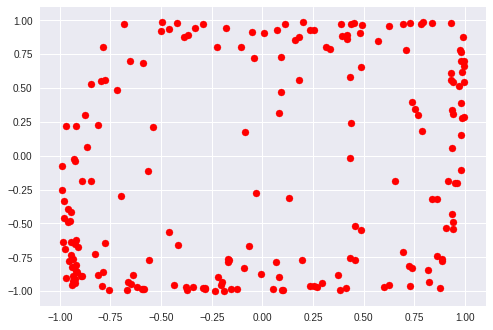

Epoch: [100/1000]
Discriminator Loss: 1.3240, Generator Loss: 0.8204
D(x): 0.5442, D(G(z)): 0.4851
Epoch: [101/1000]
Discriminator Loss: 1.2738, Generator Loss: 0.8803
D(x): 0.5350, D(G(z)): 0.4509
Epoch: [102/1000]
Discriminator Loss: 1.3711, Generator Loss: 0.8131
D(x): 0.5300, D(G(z)): 0.4950
Epoch: [103/1000]
Discriminator Loss: 1.2557, Generator Loss: 0.8006
D(x): 0.5749, D(G(z)): 0.4662
Epoch: [104/1000]
Discriminator Loss: 1.0530, Generator Loss: 0.7945
D(x): 0.6300, D(G(z)): 0.4154
Epoch: [105/1000]
Discriminator Loss: 1.3149, Generator Loss: 0.9268
D(x): 0.5002, D(G(z)): 0.4251
Epoch: [106/1000]
Discriminator Loss: 1.3753, Generator Loss: 0.8344
D(x): 0.5427, D(G(z)): 0.5099
Epoch: [107/1000]
Discriminator Loss: 1.2951, Generator Loss: 0.8601
D(x): 0.5234, D(G(z)): 0.4423
Epoch: [108/1000]
Discriminator Loss: 1.3596, Generator Loss: 0.8438
D(x): 0.5154, D(G(z)): 0.4813
Epoch: [109/1000]
Discriminator Loss: 1.3326, Generator Loss: 0.6518
D(x): 0.5549, D(G(z)): 0.5051


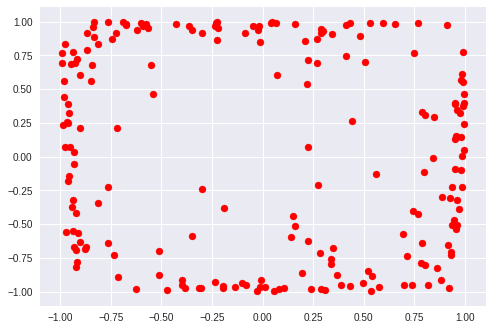

Epoch: [110/1000]
Discriminator Loss: 1.4643, Generator Loss: 0.9319
D(x): 0.5156, D(G(z)): 0.5173
Epoch: [111/1000]
Discriminator Loss: 1.3680, Generator Loss: 1.0629
D(x): 0.5252, D(G(z)): 0.4770
Epoch: [112/1000]
Discriminator Loss: 1.4012, Generator Loss: 0.7945
D(x): 0.5150, D(G(z)): 0.4838
Epoch: [113/1000]
Discriminator Loss: 1.2586, Generator Loss: 0.7484
D(x): 0.5371, D(G(z)): 0.4522
Epoch: [114/1000]
Discriminator Loss: 1.3869, Generator Loss: 0.6628
D(x): 0.4931, D(G(z)): 0.4647
Epoch: [115/1000]
Discriminator Loss: 1.3590, Generator Loss: 0.8431
D(x): 0.5200, D(G(z)): 0.4883
Epoch: [116/1000]
Discriminator Loss: 1.2777, Generator Loss: 0.7211
D(x): 0.5560, D(G(z)): 0.4788
Epoch: [117/1000]
Discriminator Loss: 1.4073, Generator Loss: 0.7957
D(x): 0.5308, D(G(z)): 0.5092
Epoch: [118/1000]
Discriminator Loss: 1.2597, Generator Loss: 0.7719
D(x): 0.5291, D(G(z)): 0.4350
Epoch: [119/1000]
Discriminator Loss: 1.2843, Generator Loss: 0.9088
D(x): 0.5411, D(G(z)): 0.4563


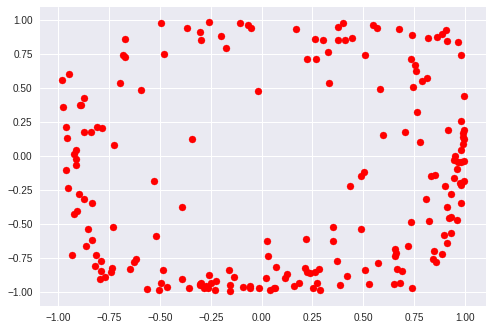

Epoch: [120/1000]
Discriminator Loss: 1.3099, Generator Loss: 0.7044
D(x): 0.5466, D(G(z)): 0.4859
Epoch: [121/1000]
Discriminator Loss: 1.2417, Generator Loss: 0.9251
D(x): 0.5415, D(G(z)): 0.4394
Epoch: [122/1000]
Discriminator Loss: 1.4024, Generator Loss: 0.7280
D(x): 0.5372, D(G(z)): 0.4967
Epoch: [123/1000]
Discriminator Loss: 1.3125, Generator Loss: 0.8955
D(x): 0.5314, D(G(z)): 0.4746
Epoch: [124/1000]
Discriminator Loss: 1.2785, Generator Loss: 0.8403
D(x): 0.5522, D(G(z)): 0.4588
Epoch: [125/1000]
Discriminator Loss: 1.3892, Generator Loss: 0.9064
D(x): 0.5407, D(G(z)): 0.4911
Epoch: [126/1000]
Discriminator Loss: 1.3450, Generator Loss: 0.8555
D(x): 0.5340, D(G(z)): 0.4740
Epoch: [127/1000]
Discriminator Loss: 1.4001, Generator Loss: 0.8877
D(x): 0.5277, D(G(z)): 0.4883
Epoch: [128/1000]
Discriminator Loss: 1.3570, Generator Loss: 0.7551
D(x): 0.5743, D(G(z)): 0.5280
Epoch: [129/1000]
Discriminator Loss: 1.4731, Generator Loss: 0.8994
D(x): 0.4905, D(G(z)): 0.4828


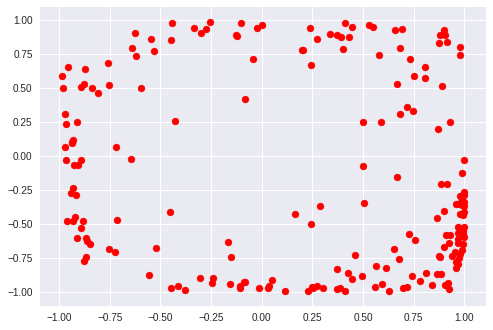

Epoch: [130/1000]
Discriminator Loss: 1.3965, Generator Loss: 0.8343
D(x): 0.5251, D(G(z)): 0.5140
Epoch: [131/1000]
Discriminator Loss: 1.3436, Generator Loss: 0.7793
D(x): 0.5069, D(G(z)): 0.4645
Epoch: [132/1000]
Discriminator Loss: 1.2956, Generator Loss: 1.2194
D(x): 0.5186, D(G(z)): 0.3973
Epoch: [133/1000]
Discriminator Loss: 1.3155, Generator Loss: 0.7921
D(x): 0.5692, D(G(z)): 0.5061
Epoch: [134/1000]
Discriminator Loss: 1.3278, Generator Loss: 0.8848
D(x): 0.5444, D(G(z)): 0.4853
Epoch: [135/1000]
Discriminator Loss: 1.2912, Generator Loss: 0.8789
D(x): 0.5263, D(G(z)): 0.4454
Epoch: [136/1000]
Discriminator Loss: 1.3591, Generator Loss: 0.9857
D(x): 0.5243, D(G(z)): 0.4882
Epoch: [137/1000]
Discriminator Loss: 1.2860, Generator Loss: 0.9089
D(x): 0.5189, D(G(z)): 0.4382
Epoch: [138/1000]
Discriminator Loss: 1.2210, Generator Loss: 0.8000
D(x): 0.5439, D(G(z)): 0.4111
Epoch: [139/1000]
Discriminator Loss: 1.2170, Generator Loss: 0.9345
D(x): 0.5782, D(G(z)): 0.4561


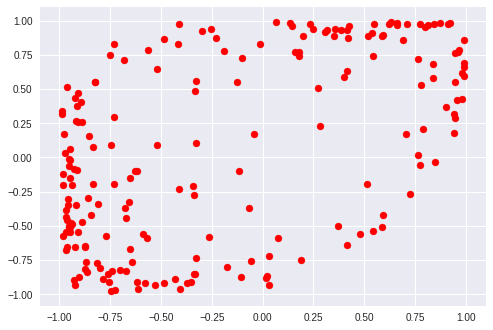

Epoch: [140/1000]
Discriminator Loss: 1.1251, Generator Loss: 0.9435
D(x): 0.5946, D(G(z)): 0.4033
Epoch: [141/1000]
Discriminator Loss: 1.2543, Generator Loss: 1.1519
D(x): 0.5804, D(G(z)): 0.4532
Epoch: [142/1000]
Discriminator Loss: 1.4492, Generator Loss: 1.0550
D(x): 0.5163, D(G(z)): 0.4767
Epoch: [143/1000]
Discriminator Loss: 1.3487, Generator Loss: 0.6954
D(x): 0.5796, D(G(z)): 0.5291
Epoch: [144/1000]
Discriminator Loss: 1.3856, Generator Loss: 0.7799
D(x): 0.5223, D(G(z)): 0.4940
Epoch: [145/1000]
Discriminator Loss: 1.4151, Generator Loss: 0.8457
D(x): 0.5091, D(G(z)): 0.5030
Epoch: [146/1000]
Discriminator Loss: 1.3378, Generator Loss: 0.7142
D(x): 0.5215, D(G(z)): 0.4841
Epoch: [147/1000]
Discriminator Loss: 1.3122, Generator Loss: 0.8824
D(x): 0.5144, D(G(z)): 0.4460
Epoch: [148/1000]
Discriminator Loss: 1.2425, Generator Loss: 1.0663
D(x): 0.5288, D(G(z)): 0.3958
Epoch: [149/1000]
Discriminator Loss: 1.3035, Generator Loss: 1.1105
D(x): 0.5563, D(G(z)): 0.4698


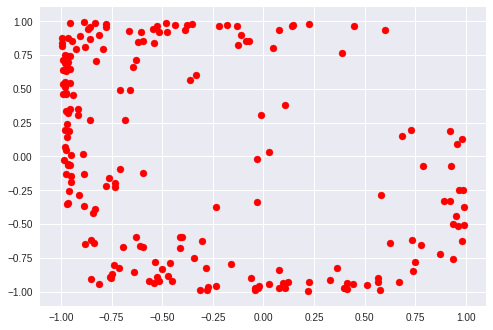

Epoch: [150/1000]
Discriminator Loss: 1.1805, Generator Loss: 1.1999
D(x): 0.5595, D(G(z)): 0.4156
Epoch: [151/1000]
Discriminator Loss: 1.3181, Generator Loss: 1.0012
D(x): 0.5315, D(G(z)): 0.4598
Epoch: [152/1000]
Discriminator Loss: 1.2566, Generator Loss: 0.7677
D(x): 0.5609, D(G(z)): 0.4503
Epoch: [153/1000]
Discriminator Loss: 1.1927, Generator Loss: 0.9075
D(x): 0.5868, D(G(z)): 0.4513
Epoch: [154/1000]
Discriminator Loss: 1.1632, Generator Loss: 1.0374
D(x): 0.5559, D(G(z)): 0.3978
Epoch: [155/1000]
Discriminator Loss: 1.3020, Generator Loss: 0.9535
D(x): 0.5485, D(G(z)): 0.4756
Epoch: [156/1000]
Discriminator Loss: 0.9950, Generator Loss: 1.0754
D(x): 0.5714, D(G(z)): 0.2924
Epoch: [157/1000]
Discriminator Loss: 1.1265, Generator Loss: 0.8813
D(x): 0.6632, D(G(z)): 0.4473
Epoch: [158/1000]
Discriminator Loss: 1.1907, Generator Loss: 1.6344
D(x): 0.5992, D(G(z)): 0.4204
Epoch: [159/1000]
Discriminator Loss: 1.4069, Generator Loss: 0.8167
D(x): 0.5104, D(G(z)): 0.4520


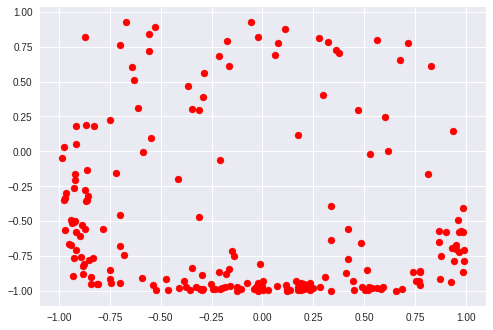

Epoch: [160/1000]
Discriminator Loss: 1.3642, Generator Loss: 0.9477
D(x): 0.5320, D(G(z)): 0.4800
Epoch: [161/1000]
Discriminator Loss: 1.3111, Generator Loss: 1.0306
D(x): 0.5340, D(G(z)): 0.4526
Epoch: [162/1000]
Discriminator Loss: 1.2684, Generator Loss: 1.0324
D(x): 0.5506, D(G(z)): 0.3999
Epoch: [163/1000]
Discriminator Loss: 1.1429, Generator Loss: 0.9638
D(x): 0.6279, D(G(z)): 0.4402
Epoch: [164/1000]
Discriminator Loss: 1.2111, Generator Loss: 1.2072
D(x): 0.5729, D(G(z)): 0.3919
Epoch: [165/1000]
Discriminator Loss: 1.2455, Generator Loss: 0.9896
D(x): 0.5721, D(G(z)): 0.4140
Epoch: [166/1000]
Discriminator Loss: 1.2239, Generator Loss: 1.1162
D(x): 0.6169, D(G(z)): 0.4359
Epoch: [167/1000]
Discriminator Loss: 1.1891, Generator Loss: 1.2796
D(x): 0.6076, D(G(z)): 0.3770
Epoch: [168/1000]
Discriminator Loss: 0.9833, Generator Loss: 0.9880
D(x): 0.6645, D(G(z)): 0.3734
Epoch: [169/1000]
Discriminator Loss: 1.0787, Generator Loss: 1.0736
D(x): 0.6460, D(G(z)): 0.3648


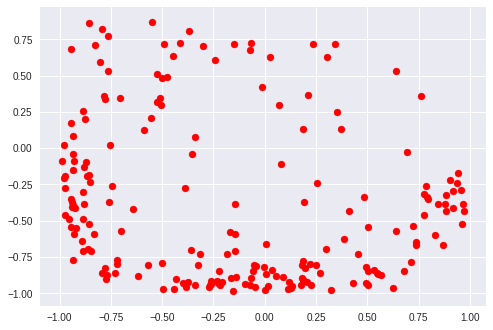

Epoch: [170/1000]
Discriminator Loss: 1.0991, Generator Loss: 1.2310
D(x): 0.6198, D(G(z)): 0.3963
Epoch: [171/1000]
Discriminator Loss: 1.1938, Generator Loss: 1.2210
D(x): 0.5951, D(G(z)): 0.4200
Epoch: [172/1000]
Discriminator Loss: 1.2645, Generator Loss: 1.4296
D(x): 0.5022, D(G(z)): 0.3967
Epoch: [173/1000]
Discriminator Loss: 1.3682, Generator Loss: 0.8317
D(x): 0.5473, D(G(z)): 0.4899
Epoch: [174/1000]
Discriminator Loss: 1.5023, Generator Loss: 0.8776
D(x): 0.4795, D(G(z)): 0.4901
Epoch: [175/1000]
Discriminator Loss: 1.2831, Generator Loss: 0.8847
D(x): 0.5914, D(G(z)): 0.5043
Epoch: [176/1000]
Discriminator Loss: 1.3742, Generator Loss: 1.0862
D(x): 0.4908, D(G(z)): 0.4236
Epoch: [177/1000]
Discriminator Loss: 1.2388, Generator Loss: 0.9577
D(x): 0.6219, D(G(z)): 0.5065
Epoch: [178/1000]
Discriminator Loss: 1.4785, Generator Loss: 1.0061
D(x): 0.5277, D(G(z)): 0.5048
Epoch: [179/1000]
Discriminator Loss: 1.3337, Generator Loss: 0.9608
D(x): 0.5579, D(G(z)): 0.4801


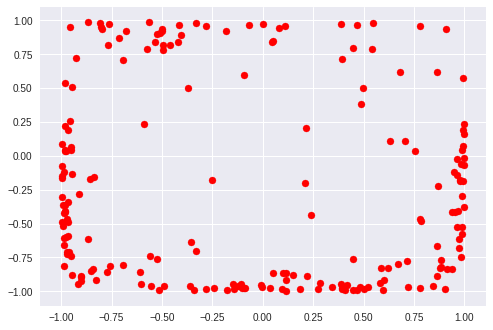

Epoch: [180/1000]
Discriminator Loss: 1.3423, Generator Loss: 0.7897
D(x): 0.5210, D(G(z)): 0.4734
Epoch: [181/1000]
Discriminator Loss: 1.4035, Generator Loss: 0.8043
D(x): 0.5104, D(G(z)): 0.4969
Epoch: [182/1000]
Discriminator Loss: 1.3311, Generator Loss: 0.7938
D(x): 0.5487, D(G(z)): 0.4955
Epoch: [183/1000]
Discriminator Loss: 1.2404, Generator Loss: 0.9217
D(x): 0.5457, D(G(z)): 0.4517
Epoch: [184/1000]
Discriminator Loss: 1.1429, Generator Loss: 0.8903
D(x): 0.5384, D(G(z)): 0.3821
Epoch: [185/1000]
Discriminator Loss: 1.2561, Generator Loss: 0.7624
D(x): 0.5288, D(G(z)): 0.4256
Epoch: [186/1000]
Discriminator Loss: 1.3064, Generator Loss: 0.8172
D(x): 0.5120, D(G(z)): 0.4432
Epoch: [187/1000]
Discriminator Loss: 1.1753, Generator Loss: 0.9823
D(x): 0.5281, D(G(z)): 0.3666
Epoch: [188/1000]
Discriminator Loss: 1.3176, Generator Loss: 0.7895
D(x): 0.5277, D(G(z)): 0.4463
Epoch: [189/1000]
Discriminator Loss: 1.2688, Generator Loss: 0.8930
D(x): 0.5337, D(G(z)): 0.4257


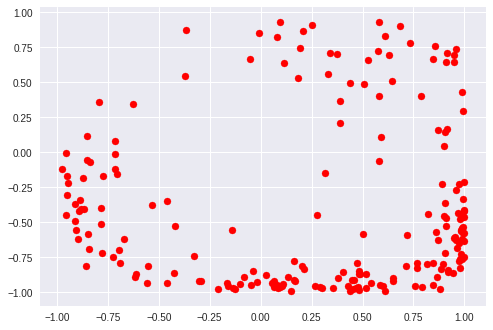

Epoch: [190/1000]
Discriminator Loss: 1.2910, Generator Loss: 0.8920
D(x): 0.5601, D(G(z)): 0.4611
Epoch: [191/1000]
Discriminator Loss: 1.2494, Generator Loss: 0.8434
D(x): 0.5271, D(G(z)): 0.3940
Epoch: [192/1000]
Discriminator Loss: 1.4052, Generator Loss: 1.1080
D(x): 0.5754, D(G(z)): 0.4950
Epoch: [193/1000]
Discriminator Loss: 1.2655, Generator Loss: 0.7263
D(x): 0.5699, D(G(z)): 0.4874
Epoch: [194/1000]
Discriminator Loss: 1.3735, Generator Loss: 0.8254
D(x): 0.4796, D(G(z)): 0.4299
Epoch: [195/1000]
Discriminator Loss: 1.3472, Generator Loss: 0.7530
D(x): 0.5515, D(G(z)): 0.5072
Epoch: [196/1000]
Discriminator Loss: 1.3964, Generator Loss: 1.1201
D(x): 0.5134, D(G(z)): 0.4798
Epoch: [197/1000]
Discriminator Loss: 1.2236, Generator Loss: 0.8226
D(x): 0.5251, D(G(z)): 0.3746
Epoch: [198/1000]
Discriminator Loss: 1.1304, Generator Loss: 0.8787
D(x): 0.6208, D(G(z)): 0.4163
Epoch: [199/1000]
Discriminator Loss: 1.1878, Generator Loss: 1.2996
D(x): 0.5754, D(G(z)): 0.3841


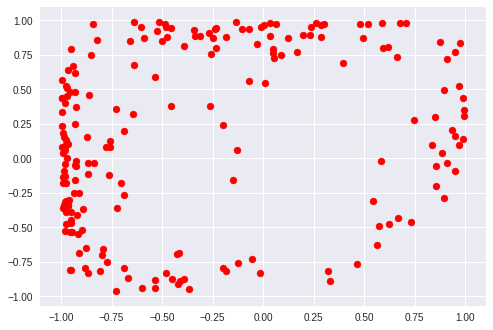

Epoch: [200/1000]
Discriminator Loss: 1.2075, Generator Loss: 0.9624
D(x): 0.5861, D(G(z)): 0.4499
Epoch: [201/1000]
Discriminator Loss: 1.2428, Generator Loss: 0.8727
D(x): 0.5743, D(G(z)): 0.4520
Epoch: [202/1000]
Discriminator Loss: 1.3214, Generator Loss: 0.9716
D(x): 0.5299, D(G(z)): 0.4382
Epoch: [203/1000]
Discriminator Loss: 1.3124, Generator Loss: 0.9233
D(x): 0.5417, D(G(z)): 0.4325
Epoch: [204/1000]
Discriminator Loss: 1.4558, Generator Loss: 1.0314
D(x): 0.4887, D(G(z)): 0.4469
Epoch: [205/1000]
Discriminator Loss: 1.3533, Generator Loss: 0.8097
D(x): 0.5370, D(G(z)): 0.4924
Epoch: [206/1000]
Discriminator Loss: 1.3352, Generator Loss: 0.8313
D(x): 0.5329, D(G(z)): 0.4510
Epoch: [207/1000]
Discriminator Loss: 1.2672, Generator Loss: 0.7406
D(x): 0.5710, D(G(z)): 0.4863
Epoch: [208/1000]
Discriminator Loss: 1.4201, Generator Loss: 0.9176
D(x): 0.5120, D(G(z)): 0.4960
Epoch: [209/1000]
Discriminator Loss: 1.3415, Generator Loss: 0.9771
D(x): 0.5136, D(G(z)): 0.4469


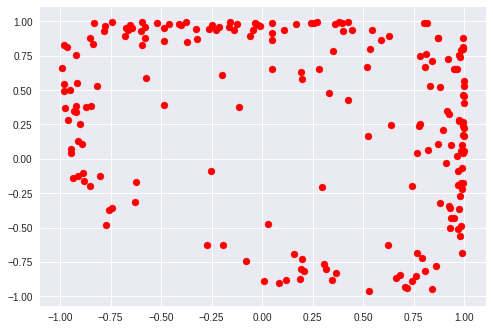

Epoch: [210/1000]
Discriminator Loss: 1.2566, Generator Loss: 0.7753
D(x): 0.5678, D(G(z)): 0.4358
Epoch: [211/1000]
Discriminator Loss: 1.2090, Generator Loss: 0.9732
D(x): 0.5904, D(G(z)): 0.4347
Epoch: [212/1000]
Discriminator Loss: 1.3720, Generator Loss: 0.9236
D(x): 0.5605, D(G(z)): 0.4637
Epoch: [213/1000]
Discriminator Loss: 1.2757, Generator Loss: 1.0758
D(x): 0.5647, D(G(z)): 0.4399
Epoch: [214/1000]
Discriminator Loss: 1.4501, Generator Loss: 0.7972
D(x): 0.4968, D(G(z)): 0.5092
Epoch: [215/1000]
Discriminator Loss: 1.3263, Generator Loss: 0.8175
D(x): 0.5365, D(G(z)): 0.4929
Epoch: [216/1000]
Discriminator Loss: 1.2794, Generator Loss: 0.7505
D(x): 0.5314, D(G(z)): 0.4596
Epoch: [217/1000]
Discriminator Loss: 1.3289, Generator Loss: 0.8352
D(x): 0.5492, D(G(z)): 0.4921
Epoch: [218/1000]
Discriminator Loss: 1.3381, Generator Loss: 0.7714
D(x): 0.5348, D(G(z)): 0.4922
Epoch: [219/1000]
Discriminator Loss: 1.3031, Generator Loss: 0.8876
D(x): 0.4980, D(G(z)): 0.4261


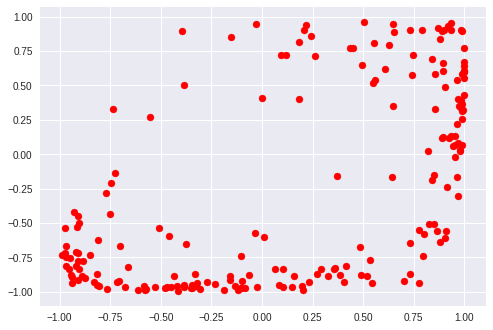

Epoch: [220/1000]
Discriminator Loss: 1.3762, Generator Loss: 0.7673
D(x): 0.5292, D(G(z)): 0.4881
Epoch: [221/1000]
Discriminator Loss: 1.4254, Generator Loss: 0.9495
D(x): 0.5218, D(G(z)): 0.4850
Epoch: [222/1000]
Discriminator Loss: 1.2272, Generator Loss: 0.8624
D(x): 0.5108, D(G(z)): 0.3957
Epoch: [223/1000]
Discriminator Loss: 1.1970, Generator Loss: 0.8278
D(x): 0.6158, D(G(z)): 0.4708
Epoch: [224/1000]
Discriminator Loss: 1.2075, Generator Loss: 0.9736
D(x): 0.5746, D(G(z)): 0.4164
Epoch: [225/1000]
Discriminator Loss: 1.0763, Generator Loss: 1.0509
D(x): 0.6185, D(G(z)): 0.3996
Epoch: [226/1000]
Discriminator Loss: 1.1900, Generator Loss: 0.8271
D(x): 0.5920, D(G(z)): 0.4267
Epoch: [227/1000]
Discriminator Loss: 1.3738, Generator Loss: 1.1828
D(x): 0.5528, D(G(z)): 0.4457
Epoch: [228/1000]
Discriminator Loss: 1.2608, Generator Loss: 0.8264
D(x): 0.5823, D(G(z)): 0.4796
Epoch: [229/1000]
Discriminator Loss: 1.3142, Generator Loss: 0.9343
D(x): 0.5396, D(G(z)): 0.4571


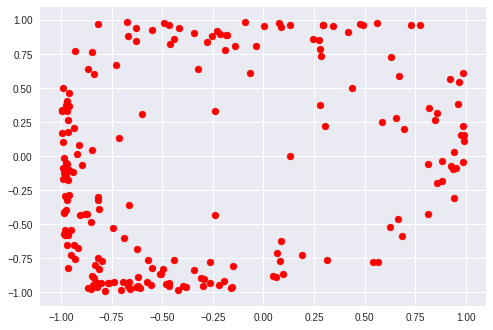

Epoch: [230/1000]
Discriminator Loss: 1.3698, Generator Loss: 0.7162
D(x): 0.5314, D(G(z)): 0.4966
Epoch: [231/1000]
Discriminator Loss: 1.3522, Generator Loss: 0.9319
D(x): 0.5314, D(G(z)): 0.4943
Epoch: [232/1000]
Discriminator Loss: 1.2884, Generator Loss: 0.9399
D(x): 0.4872, D(G(z)): 0.3958
Epoch: [233/1000]
Discriminator Loss: 1.1930, Generator Loss: 0.8400
D(x): 0.5864, D(G(z)): 0.4451
Epoch: [234/1000]
Discriminator Loss: 1.0753, Generator Loss: 0.8558
D(x): 0.6295, D(G(z)): 0.3937
Epoch: [235/1000]
Discriminator Loss: 1.3859, Generator Loss: 0.8261
D(x): 0.5659, D(G(z)): 0.5177
Epoch: [236/1000]
Discriminator Loss: 1.2006, Generator Loss: 0.9842
D(x): 0.5777, D(G(z)): 0.4492
Epoch: [237/1000]
Discriminator Loss: 1.3664, Generator Loss: 0.8248
D(x): 0.5505, D(G(z)): 0.5094
Epoch: [238/1000]
Discriminator Loss: 1.3723, Generator Loss: 0.7474
D(x): 0.5256, D(G(z)): 0.4960
Epoch: [239/1000]
Discriminator Loss: 1.4017, Generator Loss: 0.7914
D(x): 0.5188, D(G(z)): 0.5008


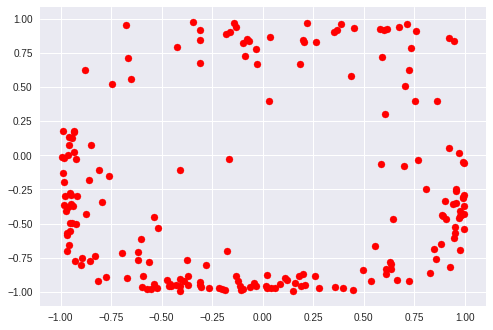

Epoch: [240/1000]
Discriminator Loss: 1.4238, Generator Loss: 0.7502
D(x): 0.5014, D(G(z)): 0.4946
Epoch: [241/1000]
Discriminator Loss: 1.3332, Generator Loss: 0.8132
D(x): 0.5219, D(G(z)): 0.4805
Epoch: [242/1000]
Discriminator Loss: 1.3614, Generator Loss: 0.7801
D(x): 0.5092, D(G(z)): 0.4617
Epoch: [243/1000]
Discriminator Loss: 1.3321, Generator Loss: 0.7522
D(x): 0.5392, D(G(z)): 0.4803
Epoch: [244/1000]
Discriminator Loss: 1.3315, Generator Loss: 0.7928
D(x): 0.5340, D(G(z)): 0.4773
Epoch: [245/1000]
Discriminator Loss: 1.3660, Generator Loss: 0.8647
D(x): 0.5091, D(G(z)): 0.4707
Epoch: [246/1000]
Discriminator Loss: 1.4011, Generator Loss: 0.7945
D(x): 0.5035, D(G(z)): 0.4832
Epoch: [247/1000]
Discriminator Loss: 1.3643, Generator Loss: 0.7103
D(x): 0.5386, D(G(z)): 0.5079
Epoch: [248/1000]
Discriminator Loss: 1.4706, Generator Loss: 0.7093
D(x): 0.4607, D(G(z)): 0.4703
Epoch: [249/1000]
Discriminator Loss: 1.3662, Generator Loss: 0.6719
D(x): 0.5214, D(G(z)): 0.4964


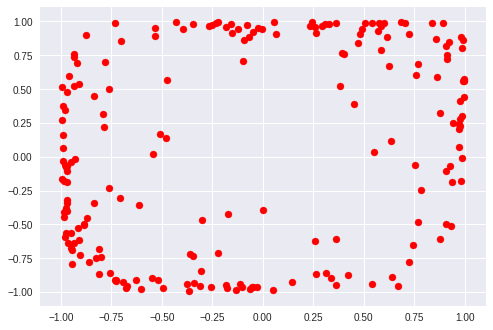

Epoch: [250/1000]
Discriminator Loss: 1.2801, Generator Loss: 0.8439
D(x): 0.5429, D(G(z)): 0.4672
Epoch: [251/1000]
Discriminator Loss: 1.3525, Generator Loss: 0.9092
D(x): 0.5263, D(G(z)): 0.4735
Epoch: [252/1000]
Discriminator Loss: 1.3443, Generator Loss: 0.7861
D(x): 0.5584, D(G(z)): 0.5010
Epoch: [253/1000]
Discriminator Loss: 1.3200, Generator Loss: 0.8641
D(x): 0.5278, D(G(z)): 0.4586
Epoch: [254/1000]
Discriminator Loss: 1.3649, Generator Loss: 0.8693
D(x): 0.4998, D(G(z)): 0.4725
Epoch: [255/1000]
Discriminator Loss: 1.3809, Generator Loss: 0.8708
D(x): 0.5144, D(G(z)): 0.4767
Epoch: [256/1000]
Discriminator Loss: 1.2908, Generator Loss: 0.7956
D(x): 0.5389, D(G(z)): 0.4521
Epoch: [257/1000]
Discriminator Loss: 1.2158, Generator Loss: 0.9425
D(x): 0.5507, D(G(z)): 0.4293
Epoch: [258/1000]
Discriminator Loss: 1.3161, Generator Loss: 0.6828
D(x): 0.5448, D(G(z)): 0.4961
Epoch: [259/1000]
Discriminator Loss: 1.2631, Generator Loss: 0.7982
D(x): 0.5365, D(G(z)): 0.4520


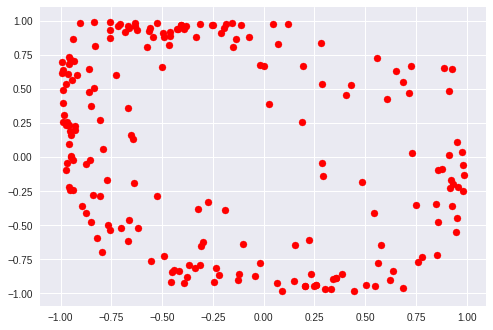

Epoch: [260/1000]
Discriminator Loss: 1.4176, Generator Loss: 1.2305
D(x): 0.4905, D(G(z)): 0.4539
Epoch: [261/1000]
Discriminator Loss: 1.3257, Generator Loss: 0.7250
D(x): 0.5559, D(G(z)): 0.5013
Epoch: [262/1000]
Discriminator Loss: 1.3607, Generator Loss: 1.0537
D(x): 0.4889, D(G(z)): 0.4185
Epoch: [263/1000]
Discriminator Loss: 1.4335, Generator Loss: 0.8325
D(x): 0.5255, D(G(z)): 0.5086
Epoch: [264/1000]
Discriminator Loss: 1.2786, Generator Loss: 0.8174
D(x): 0.5288, D(G(z)): 0.4517
Epoch: [265/1000]
Discriminator Loss: 1.4505, Generator Loss: 0.6603
D(x): 0.5041, D(G(z)): 0.5085
Epoch: [266/1000]
Discriminator Loss: 1.2852, Generator Loss: 0.6668
D(x): 0.5413, D(G(z)): 0.4751
Epoch: [267/1000]
Discriminator Loss: 1.2841, Generator Loss: 0.8150
D(x): 0.5347, D(G(z)): 0.4539
Epoch: [268/1000]
Discriminator Loss: 1.1516, Generator Loss: 1.2279
D(x): 0.5867, D(G(z)): 0.4174
Epoch: [269/1000]
Discriminator Loss: 1.0642, Generator Loss: 0.9424
D(x): 0.6469, D(G(z)): 0.4018


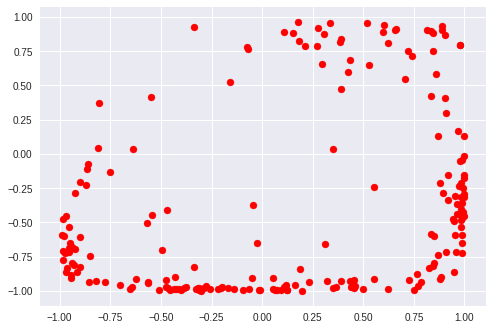

Epoch: [270/1000]
Discriminator Loss: 1.1543, Generator Loss: 0.8969
D(x): 0.6298, D(G(z)): 0.4386
Epoch: [271/1000]
Discriminator Loss: 1.0177, Generator Loss: 0.9219
D(x): 0.6075, D(G(z)): 0.3654
Epoch: [272/1000]
Discriminator Loss: 1.3100, Generator Loss: 0.8521
D(x): 0.5612, D(G(z)): 0.4913
Epoch: [273/1000]
Discriminator Loss: 1.3094, Generator Loss: 0.8399
D(x): 0.5129, D(G(z)): 0.4469
Epoch: [274/1000]
Discriminator Loss: 1.3739, Generator Loss: 0.8592
D(x): 0.4827, D(G(z)): 0.4607
Epoch: [275/1000]
Discriminator Loss: 1.3807, Generator Loss: 0.7949
D(x): 0.5105, D(G(z)): 0.4876
Epoch: [276/1000]
Discriminator Loss: 1.3202, Generator Loss: 0.7960
D(x): 0.5207, D(G(z)): 0.4749
Epoch: [277/1000]
Discriminator Loss: 1.2939, Generator Loss: 0.8706
D(x): 0.5263, D(G(z)): 0.4538
Epoch: [278/1000]
Discriminator Loss: 1.3192, Generator Loss: 0.8332
D(x): 0.4900, D(G(z)): 0.4279
Epoch: [279/1000]
Discriminator Loss: 1.3309, Generator Loss: 1.0200
D(x): 0.5813, D(G(z)): 0.4894


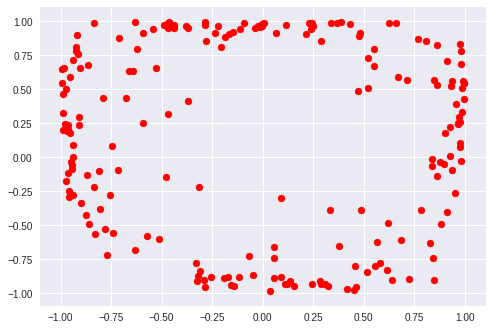

Epoch: [280/1000]
Discriminator Loss: 1.2946, Generator Loss: 0.8474
D(x): 0.5584, D(G(z)): 0.4526
Epoch: [281/1000]
Discriminator Loss: 1.2931, Generator Loss: 0.7489
D(x): 0.5322, D(G(z)): 0.4573
Epoch: [282/1000]
Discriminator Loss: 1.3172, Generator Loss: 0.7626
D(x): 0.5254, D(G(z)): 0.4707
Epoch: [283/1000]
Discriminator Loss: 1.3961, Generator Loss: 0.6882
D(x): 0.5305, D(G(z)): 0.5108
Epoch: [284/1000]
Discriminator Loss: 1.2914, Generator Loss: 0.7341
D(x): 0.5343, D(G(z)): 0.4665
Epoch: [285/1000]
Discriminator Loss: 1.3788, Generator Loss: 0.7879
D(x): 0.5105, D(G(z)): 0.4724
Epoch: [286/1000]
Discriminator Loss: 1.2650, Generator Loss: 0.9106
D(x): 0.5586, D(G(z)): 0.4486
Epoch: [287/1000]
Discriminator Loss: 1.2616, Generator Loss: 1.0338
D(x): 0.5665, D(G(z)): 0.4786
Epoch: [288/1000]
Discriminator Loss: 1.4440, Generator Loss: 0.8855
D(x): 0.4784, D(G(z)): 0.4836
Epoch: [289/1000]
Discriminator Loss: 1.3831, Generator Loss: 0.8012
D(x): 0.5238, D(G(z)): 0.5000


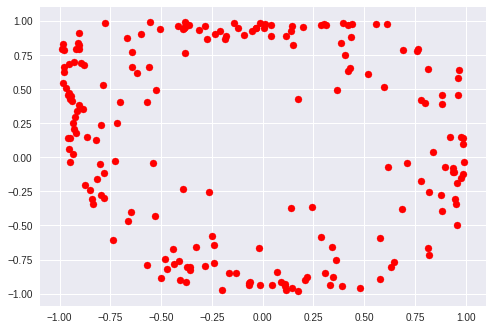

Epoch: [290/1000]
Discriminator Loss: 1.4572, Generator Loss: 0.6628
D(x): 0.4780, D(G(z)): 0.4964
Epoch: [291/1000]
Discriminator Loss: 1.4298, Generator Loss: 0.8798
D(x): 0.5050, D(G(z)): 0.5065
Epoch: [292/1000]
Discriminator Loss: 1.2780, Generator Loss: 0.8598
D(x): 0.5235, D(G(z)): 0.4243
Epoch: [293/1000]
Discriminator Loss: 1.2518, Generator Loss: 0.8354
D(x): 0.5372, D(G(z)): 0.4287
Epoch: [294/1000]
Discriminator Loss: 1.0852, Generator Loss: 1.0356
D(x): 0.6146, D(G(z)): 0.4103
Epoch: [295/1000]
Discriminator Loss: 1.1559, Generator Loss: 0.8491
D(x): 0.6086, D(G(z)): 0.4292
Epoch: [296/1000]
Discriminator Loss: 1.2737, Generator Loss: 0.9926
D(x): 0.6158, D(G(z)): 0.4780
Epoch: [297/1000]
Discriminator Loss: 1.4928, Generator Loss: 0.9732
D(x): 0.4944, D(G(z)): 0.4954
Epoch: [298/1000]
Discriminator Loss: 1.3588, Generator Loss: 0.7685
D(x): 0.4940, D(G(z)): 0.4646
Epoch: [299/1000]
Discriminator Loss: 1.3632, Generator Loss: 0.8077
D(x): 0.4905, D(G(z)): 0.4539


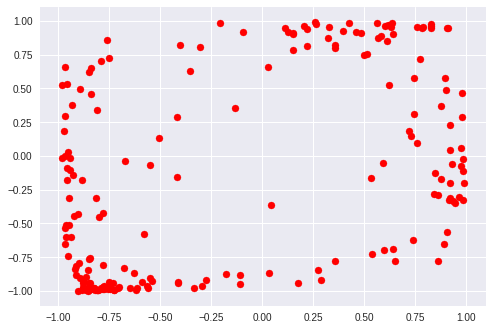

Epoch: [300/1000]
Discriminator Loss: 1.4111, Generator Loss: 0.7553
D(x): 0.5533, D(G(z)): 0.5516
Epoch: [301/1000]
Discriminator Loss: 1.3050, Generator Loss: 0.8879
D(x): 0.5002, D(G(z)): 0.4474
Epoch: [302/1000]
Discriminator Loss: 1.1995, Generator Loss: 1.0688
D(x): 0.5472, D(G(z)): 0.4124
Epoch: [303/1000]
Discriminator Loss: 1.3251, Generator Loss: 0.8494
D(x): 0.5889, D(G(z)): 0.5005
Epoch: [304/1000]
Discriminator Loss: 1.4345, Generator Loss: 0.8710
D(x): 0.5288, D(G(z)): 0.5186
Epoch: [305/1000]
Discriminator Loss: 1.4410, Generator Loss: 0.8329
D(x): 0.5086, D(G(z)): 0.5153
Epoch: [306/1000]
Discriminator Loss: 1.3249, Generator Loss: 0.7627
D(x): 0.5209, D(G(z)): 0.4753
Epoch: [307/1000]
Discriminator Loss: 1.2919, Generator Loss: 0.7575
D(x): 0.5259, D(G(z)): 0.4605
Epoch: [308/1000]
Discriminator Loss: 1.2233, Generator Loss: 0.9463
D(x): 0.5193, D(G(z)): 0.3591
Epoch: [309/1000]
Discriminator Loss: 1.2596, Generator Loss: 0.9573
D(x): 0.5560, D(G(z)): 0.4481


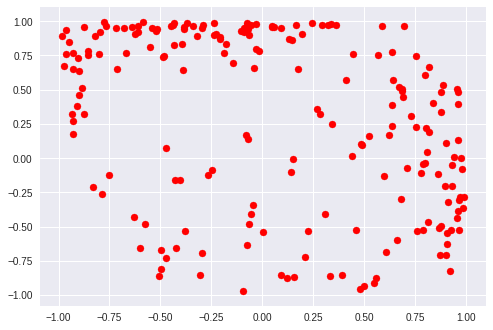

Epoch: [310/1000]
Discriminator Loss: 1.2028, Generator Loss: 0.7902
D(x): 0.5593, D(G(z)): 0.4099
Epoch: [311/1000]
Discriminator Loss: 1.1996, Generator Loss: 1.3098
D(x): 0.5887, D(G(z)): 0.4225
Epoch: [312/1000]
Discriminator Loss: 1.3263, Generator Loss: 1.1015
D(x): 0.5633, D(G(z)): 0.4312
Epoch: [313/1000]
Discriminator Loss: 1.2197, Generator Loss: 0.9295
D(x): 0.5542, D(G(z)): 0.3886
Epoch: [314/1000]
Discriminator Loss: 1.2086, Generator Loss: 0.9916
D(x): 0.5804, D(G(z)): 0.4276
Epoch: [315/1000]
Discriminator Loss: 1.2602, Generator Loss: 0.7436
D(x): 0.6041, D(G(z)): 0.4696
Epoch: [316/1000]
Discriminator Loss: 1.5048, Generator Loss: 0.7545
D(x): 0.5235, D(G(z)): 0.5167
Epoch: [317/1000]
Discriminator Loss: 1.2492, Generator Loss: 0.7592
D(x): 0.5693, D(G(z)): 0.4630
Epoch: [318/1000]
Discriminator Loss: 1.3736, Generator Loss: 0.7777
D(x): 0.5309, D(G(z)): 0.4944
Epoch: [319/1000]
Discriminator Loss: 1.2613, Generator Loss: 0.8153
D(x): 0.5606, D(G(z)): 0.4800


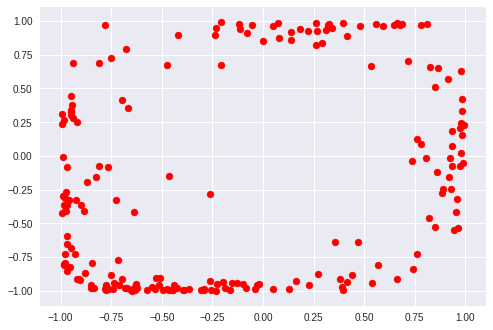

Epoch: [320/1000]
Discriminator Loss: 1.3898, Generator Loss: 0.8272
D(x): 0.4969, D(G(z)): 0.4758
Epoch: [321/1000]
Discriminator Loss: 1.4521, Generator Loss: 0.7422
D(x): 0.5049, D(G(z)): 0.5068
Epoch: [322/1000]
Discriminator Loss: 1.3038, Generator Loss: 0.7746
D(x): 0.5218, D(G(z)): 0.4616
Epoch: [323/1000]
Discriminator Loss: 1.4204, Generator Loss: 1.0884
D(x): 0.5032, D(G(z)): 0.4923
Epoch: [324/1000]
Discriminator Loss: 1.3462, Generator Loss: 0.9546
D(x): 0.5334, D(G(z)): 0.4702
Epoch: [325/1000]
Discriminator Loss: 1.3564, Generator Loss: 0.6872
D(x): 0.5603, D(G(z)): 0.5292
Epoch: [326/1000]
Discriminator Loss: 1.3160, Generator Loss: 0.7235
D(x): 0.5345, D(G(z)): 0.4872
Epoch: [327/1000]
Discriminator Loss: 1.3885, Generator Loss: 0.7727
D(x): 0.4930, D(G(z)): 0.4807
Epoch: [328/1000]
Discriminator Loss: 1.3140, Generator Loss: 1.0193
D(x): 0.5183, D(G(z)): 0.4610
Epoch: [329/1000]
Discriminator Loss: 1.4391, Generator Loss: 0.8262
D(x): 0.5005, D(G(z)): 0.4973


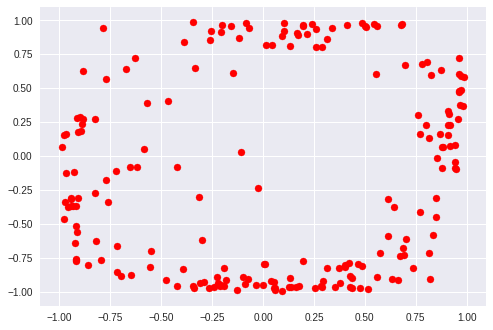

Epoch: [330/1000]
Discriminator Loss: 1.4345, Generator Loss: 0.8264
D(x): 0.4889, D(G(z)): 0.4884
Epoch: [331/1000]
Discriminator Loss: 1.3282, Generator Loss: 0.8037
D(x): 0.5147, D(G(z)): 0.4714
Epoch: [332/1000]
Discriminator Loss: 1.4283, Generator Loss: 0.8640
D(x): 0.4995, D(G(z)): 0.4860
Epoch: [333/1000]
Discriminator Loss: 1.3933, Generator Loss: 0.7247
D(x): 0.5033, D(G(z)): 0.4904
Epoch: [334/1000]
Discriminator Loss: 1.2587, Generator Loss: 0.7392
D(x): 0.5165, D(G(z)): 0.4199
Epoch: [335/1000]
Discriminator Loss: 1.3248, Generator Loss: 0.9654
D(x): 0.5435, D(G(z)): 0.4689
Epoch: [336/1000]
Discriminator Loss: 1.3122, Generator Loss: 0.8949
D(x): 0.5323, D(G(z)): 0.4578
Epoch: [337/1000]
Discriminator Loss: 1.3614, Generator Loss: 0.7587
D(x): 0.5352, D(G(z)): 0.4880
Epoch: [338/1000]
Discriminator Loss: 1.3803, Generator Loss: 0.7366
D(x): 0.5775, D(G(z)): 0.5118
Epoch: [339/1000]
Discriminator Loss: 1.3520, Generator Loss: 0.6897
D(x): 0.5116, D(G(z)): 0.4814


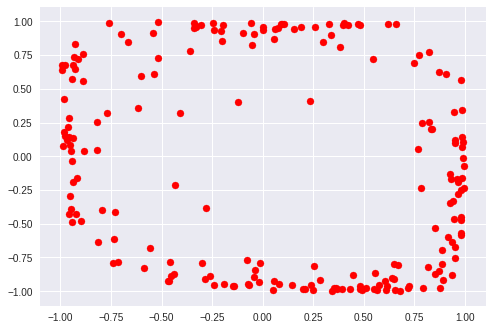

Epoch: [340/1000]
Discriminator Loss: 1.3629, Generator Loss: 0.6814
D(x): 0.5237, D(G(z)): 0.4962
Epoch: [341/1000]
Discriminator Loss: 1.3704, Generator Loss: 0.6680
D(x): 0.5402, D(G(z)): 0.5110
Epoch: [342/1000]
Discriminator Loss: 1.2281, Generator Loss: 1.0961
D(x): 0.5529, D(G(z)): 0.4012
Epoch: [343/1000]
Discriminator Loss: 1.4373, Generator Loss: 0.7791
D(x): 0.5136, D(G(z)): 0.5128
Epoch: [344/1000]
Discriminator Loss: 1.3247, Generator Loss: 0.8136
D(x): 0.5163, D(G(z)): 0.4729
Epoch: [345/1000]
Discriminator Loss: 1.3640, Generator Loss: 0.7500
D(x): 0.5010, D(G(z)): 0.4735
Epoch: [346/1000]
Discriminator Loss: 1.3991, Generator Loss: 0.9034
D(x): 0.4961, D(G(z)): 0.4736
Epoch: [347/1000]
Discriminator Loss: 1.2132, Generator Loss: 0.9230
D(x): 0.5683, D(G(z)): 0.4470
Epoch: [348/1000]
Discriminator Loss: 1.3321, Generator Loss: 0.8197
D(x): 0.5436, D(G(z)): 0.4831
Epoch: [349/1000]
Discriminator Loss: 1.4360, Generator Loss: 0.9416
D(x): 0.5142, D(G(z)): 0.5067


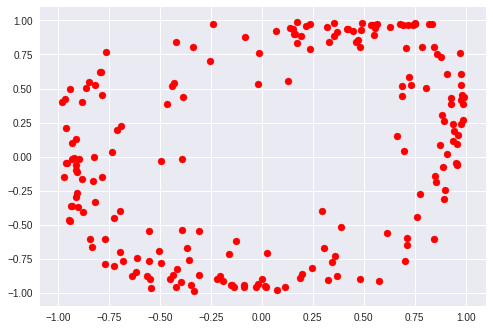

Epoch: [350/1000]
Discriminator Loss: 1.3362, Generator Loss: 0.7991
D(x): 0.5215, D(G(z)): 0.4772
Epoch: [351/1000]
Discriminator Loss: 1.2570, Generator Loss: 0.9388
D(x): 0.5318, D(G(z)): 0.4352
Epoch: [352/1000]
Discriminator Loss: 1.3445, Generator Loss: 0.9073
D(x): 0.5194, D(G(z)): 0.4566
Epoch: [353/1000]
Discriminator Loss: 1.2826, Generator Loss: 0.7935
D(x): 0.5585, D(G(z)): 0.4804
Epoch: [354/1000]
Discriminator Loss: 1.2830, Generator Loss: 0.9284
D(x): 0.5491, D(G(z)): 0.4256
Epoch: [355/1000]
Discriminator Loss: 1.2021, Generator Loss: 1.2256
D(x): 0.6029, D(G(z)): 0.4046
Epoch: [356/1000]
Discriminator Loss: 1.2926, Generator Loss: 0.8302
D(x): 0.5490, D(G(z)): 0.4603
Epoch: [357/1000]
Discriminator Loss: 1.4135, Generator Loss: 0.9091
D(x): 0.5274, D(G(z)): 0.4862
Epoch: [358/1000]
Discriminator Loss: 1.4892, Generator Loss: 0.7025
D(x): 0.4861, D(G(z)): 0.4867
Epoch: [359/1000]
Discriminator Loss: 1.4756, Generator Loss: 0.7855
D(x): 0.4748, D(G(z)): 0.4860


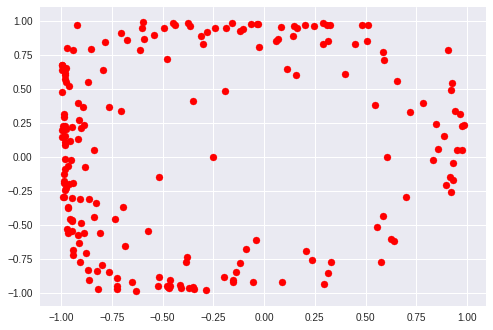

Epoch: [360/1000]
Discriminator Loss: 1.3499, Generator Loss: 0.7420
D(x): 0.5150, D(G(z)): 0.4738
Epoch: [361/1000]
Discriminator Loss: 1.3371, Generator Loss: 0.8896
D(x): 0.5088, D(G(z)): 0.4502
Epoch: [362/1000]
Discriminator Loss: 1.3439, Generator Loss: 0.8642
D(x): 0.5436, D(G(z)): 0.4934
Epoch: [363/1000]
Discriminator Loss: 1.3777, Generator Loss: 0.7256
D(x): 0.4840, D(G(z)): 0.4500
Epoch: [364/1000]
Discriminator Loss: 1.3629, Generator Loss: 0.8131
D(x): 0.5036, D(G(z)): 0.4607
Epoch: [365/1000]
Discriminator Loss: 1.3387, Generator Loss: 0.9653
D(x): 0.5563, D(G(z)): 0.5162
Epoch: [366/1000]
Discriminator Loss: 1.2846, Generator Loss: 0.7779
D(x): 0.5078, D(G(z)): 0.4337
Epoch: [367/1000]
Discriminator Loss: 1.2958, Generator Loss: 0.7840
D(x): 0.5707, D(G(z)): 0.4976
Epoch: [368/1000]
Discriminator Loss: 1.3304, Generator Loss: 1.0825
D(x): 0.5312, D(G(z)): 0.4478
Epoch: [369/1000]
Discriminator Loss: 1.5287, Generator Loss: 0.8533
D(x): 0.4982, D(G(z)): 0.5101


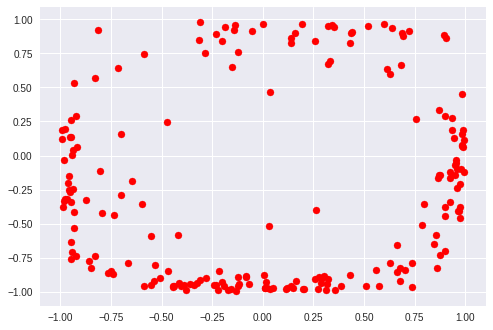

Epoch: [370/1000]
Discriminator Loss: 1.3595, Generator Loss: 0.7365
D(x): 0.5252, D(G(z)): 0.4954
Epoch: [371/1000]
Discriminator Loss: 1.3865, Generator Loss: 0.7808
D(x): 0.4887, D(G(z)): 0.4625
Epoch: [372/1000]
Discriminator Loss: 1.5143, Generator Loss: 0.7433
D(x): 0.5005, D(G(z)): 0.5447
Epoch: [373/1000]
Discriminator Loss: 1.3214, Generator Loss: 0.7694
D(x): 0.5061, D(G(z)): 0.4618
Epoch: [374/1000]
Discriminator Loss: 1.3085, Generator Loss: 0.7862
D(x): 0.5263, D(G(z)): 0.4726
Epoch: [375/1000]
Discriminator Loss: 1.3962, Generator Loss: 0.8559
D(x): 0.4899, D(G(z)): 0.4490
Epoch: [376/1000]
Discriminator Loss: 1.1966, Generator Loss: 0.8335
D(x): 0.5911, D(G(z)): 0.4521
Epoch: [377/1000]
Discriminator Loss: 1.3106, Generator Loss: 0.8718
D(x): 0.5433, D(G(z)): 0.4607
Epoch: [378/1000]
Discriminator Loss: 1.3403, Generator Loss: 0.7944
D(x): 0.5610, D(G(z)): 0.5144
Epoch: [379/1000]
Discriminator Loss: 1.3226, Generator Loss: 0.7475
D(x): 0.5359, D(G(z)): 0.4855


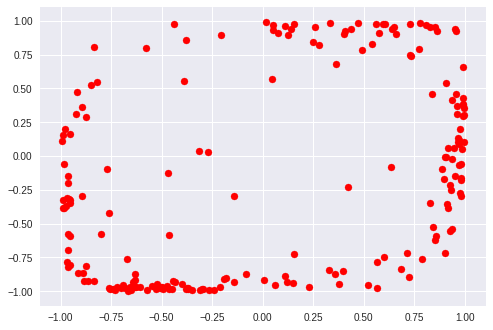

Epoch: [380/1000]
Discriminator Loss: 1.3414, Generator Loss: 0.9542
D(x): 0.5682, D(G(z)): 0.4984
Epoch: [381/1000]
Discriminator Loss: 1.3245, Generator Loss: 0.7166
D(x): 0.5313, D(G(z)): 0.4732
Epoch: [382/1000]
Discriminator Loss: 1.3512, Generator Loss: 0.9546
D(x): 0.5201, D(G(z)): 0.4842
Epoch: [383/1000]
Discriminator Loss: 1.3718, Generator Loss: 0.7409
D(x): 0.5368, D(G(z)): 0.5086
Epoch: [384/1000]
Discriminator Loss: 1.3172, Generator Loss: 0.7539
D(x): 0.5416, D(G(z)): 0.4844
Epoch: [385/1000]
Discriminator Loss: 1.4528, Generator Loss: 0.7567
D(x): 0.4951, D(G(z)): 0.5162
Epoch: [386/1000]
Discriminator Loss: 1.3961, Generator Loss: 0.7099
D(x): 0.5122, D(G(z)): 0.5104
Epoch: [387/1000]
Discriminator Loss: 1.2938, Generator Loss: 0.8614
D(x): 0.5085, D(G(z)): 0.4448
Epoch: [388/1000]
Discriminator Loss: 1.3146, Generator Loss: 0.7623
D(x): 0.5233, D(G(z)): 0.4734
Epoch: [389/1000]
Discriminator Loss: 1.4186, Generator Loss: 0.8064
D(x): 0.4928, D(G(z)): 0.4920


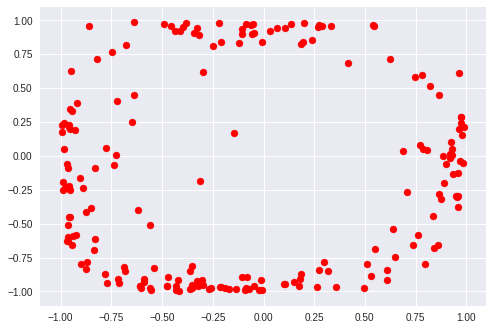

Epoch: [390/1000]
Discriminator Loss: 1.3587, Generator Loss: 0.7888
D(x): 0.4883, D(G(z)): 0.4553
Epoch: [391/1000]
Discriminator Loss: 1.3498, Generator Loss: 0.8277
D(x): 0.5110, D(G(z)): 0.4692
Epoch: [392/1000]
Discriminator Loss: 1.3842, Generator Loss: 0.7359
D(x): 0.5444, D(G(z)): 0.5241
Epoch: [393/1000]
Discriminator Loss: 1.2724, Generator Loss: 0.6774
D(x): 0.5433, D(G(z)): 0.4739
Epoch: [394/1000]
Discriminator Loss: 1.3660, Generator Loss: 0.7603
D(x): 0.5092, D(G(z)): 0.4856
Epoch: [395/1000]
Discriminator Loss: 1.3230, Generator Loss: 0.7632
D(x): 0.5276, D(G(z)): 0.4666
Epoch: [396/1000]
Discriminator Loss: 1.2947, Generator Loss: 0.7922
D(x): 0.5355, D(G(z)): 0.4610
Epoch: [397/1000]
Discriminator Loss: 1.4524, Generator Loss: 0.8073
D(x): 0.4790, D(G(z)): 0.4706
Epoch: [398/1000]
Discriminator Loss: 1.2677, Generator Loss: 0.8542
D(x): 0.5469, D(G(z)): 0.4707
Epoch: [399/1000]
Discriminator Loss: 1.3009, Generator Loss: 0.7512
D(x): 0.5146, D(G(z)): 0.4451


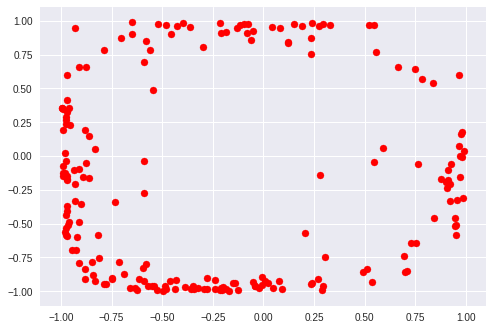

Epoch: [400/1000]
Discriminator Loss: 1.4027, Generator Loss: 0.7231
D(x): 0.5184, D(G(z)): 0.5115
Epoch: [401/1000]
Discriminator Loss: 1.3520, Generator Loss: 0.7976
D(x): 0.4981, D(G(z)): 0.4710
Epoch: [402/1000]
Discriminator Loss: 1.3082, Generator Loss: 0.7642
D(x): 0.5374, D(G(z)): 0.4861
Epoch: [403/1000]
Discriminator Loss: 1.3664, Generator Loss: 0.8030
D(x): 0.5428, D(G(z)): 0.5074
Epoch: [404/1000]
Discriminator Loss: 1.3288, Generator Loss: 0.7513
D(x): 0.5307, D(G(z)): 0.4880
Epoch: [405/1000]
Discriminator Loss: 1.3225, Generator Loss: 0.7142
D(x): 0.5263, D(G(z)): 0.4771
Epoch: [406/1000]
Discriminator Loss: 1.3866, Generator Loss: 0.6932
D(x): 0.5248, D(G(z)): 0.5106
Epoch: [407/1000]
Discriminator Loss: 1.3551, Generator Loss: 0.7588
D(x): 0.5147, D(G(z)): 0.4939
Epoch: [408/1000]
Discriminator Loss: 1.3430, Generator Loss: 0.8443
D(x): 0.4873, D(G(z)): 0.4490
Epoch: [409/1000]
Discriminator Loss: 1.3613, Generator Loss: 0.7340
D(x): 0.5302, D(G(z)): 0.5008


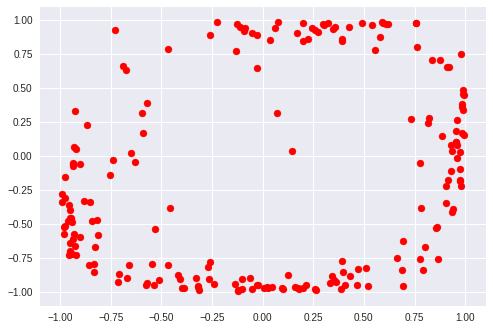

Epoch: [410/1000]
Discriminator Loss: 1.3758, Generator Loss: 0.7833
D(x): 0.5067, D(G(z)): 0.4903
Epoch: [411/1000]
Discriminator Loss: 1.3719, Generator Loss: 0.7263
D(x): 0.5134, D(G(z)): 0.4964
Epoch: [412/1000]
Discriminator Loss: 1.3605, Generator Loss: 0.8410
D(x): 0.5330, D(G(z)): 0.5026
Epoch: [413/1000]
Discriminator Loss: 1.2384, Generator Loss: 0.8082
D(x): 0.5242, D(G(z)): 0.4125
Epoch: [414/1000]
Discriminator Loss: 1.4341, Generator Loss: 0.6403
D(x): 0.5326, D(G(z)): 0.5276
Epoch: [415/1000]
Discriminator Loss: 1.3736, Generator Loss: 0.8140
D(x): 0.5254, D(G(z)): 0.5094
Epoch: [416/1000]
Discriminator Loss: 1.4068, Generator Loss: 0.8552
D(x): 0.4928, D(G(z)): 0.4876
Epoch: [417/1000]
Discriminator Loss: 1.3721, Generator Loss: 0.7287
D(x): 0.5434, D(G(z)): 0.5260
Epoch: [418/1000]
Discriminator Loss: 1.4127, Generator Loss: 0.7012
D(x): 0.4863, D(G(z)): 0.4876
Epoch: [419/1000]
Discriminator Loss: 1.4297, Generator Loss: 0.7286
D(x): 0.4805, D(G(z)): 0.4858


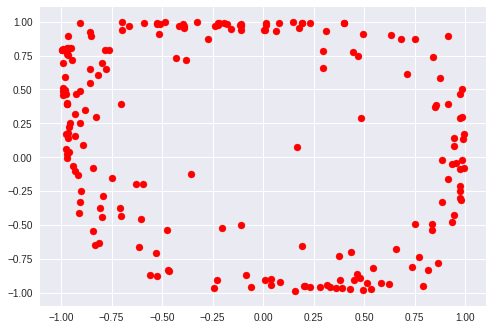

Epoch: [420/1000]
Discriminator Loss: 1.2593, Generator Loss: 0.7329
D(x): 0.5376, D(G(z)): 0.4561
Epoch: [421/1000]
Discriminator Loss: 1.2535, Generator Loss: 0.8793
D(x): 0.5421, D(G(z)): 0.4337
Epoch: [422/1000]
Discriminator Loss: 1.2851, Generator Loss: 0.8267
D(x): 0.5484, D(G(z)): 0.4774
Epoch: [423/1000]
Discriminator Loss: 1.2482, Generator Loss: 0.7887
D(x): 0.5433, D(G(z)): 0.4593
Epoch: [424/1000]
Discriminator Loss: 1.3381, Generator Loss: 0.7359
D(x): 0.4973, D(G(z)): 0.4560
Epoch: [425/1000]
Discriminator Loss: 1.3755, Generator Loss: 0.7125
D(x): 0.5156, D(G(z)): 0.4989
Epoch: [426/1000]
Discriminator Loss: 1.3102, Generator Loss: 0.7841
D(x): 0.5163, D(G(z)): 0.4668
Epoch: [427/1000]
Discriminator Loss: 1.2858, Generator Loss: 0.9862
D(x): 0.5299, D(G(z)): 0.4397
Epoch: [428/1000]
Discriminator Loss: 1.3667, Generator Loss: 0.7666
D(x): 0.5499, D(G(z)): 0.5181
Epoch: [429/1000]
Discriminator Loss: 1.4231, Generator Loss: 0.7177
D(x): 0.5127, D(G(z)): 0.5150


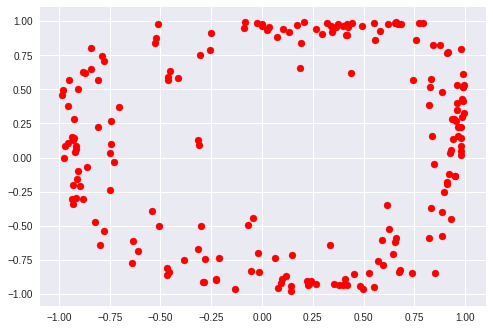

Epoch: [430/1000]
Discriminator Loss: 1.3399, Generator Loss: 1.0408
D(x): 0.5210, D(G(z)): 0.4692
Epoch: [431/1000]
Discriminator Loss: 1.2609, Generator Loss: 0.8901
D(x): 0.5574, D(G(z)): 0.4705
Epoch: [432/1000]
Discriminator Loss: 1.4115, Generator Loss: 0.7664
D(x): 0.4946, D(G(z)): 0.4732
Epoch: [433/1000]
Discriminator Loss: 1.3761, Generator Loss: 0.8286
D(x): 0.4967, D(G(z)): 0.4822
Epoch: [434/1000]
Discriminator Loss: 1.3238, Generator Loss: 0.7633
D(x): 0.5236, D(G(z)): 0.4820
Epoch: [435/1000]
Discriminator Loss: 1.2060, Generator Loss: 0.9214
D(x): 0.5629, D(G(z)): 0.4356
Epoch: [436/1000]
Discriminator Loss: 1.3003, Generator Loss: 1.0564
D(x): 0.5225, D(G(z)): 0.4334
Epoch: [437/1000]
Discriminator Loss: 1.1890, Generator Loss: 0.9194
D(x): 0.5835, D(G(z)): 0.4145
Epoch: [438/1000]
Discriminator Loss: 1.2864, Generator Loss: 0.7897
D(x): 0.5846, D(G(z)): 0.4960
Epoch: [439/1000]
Discriminator Loss: 1.3679, Generator Loss: 0.9026
D(x): 0.4765, D(G(z)): 0.3999


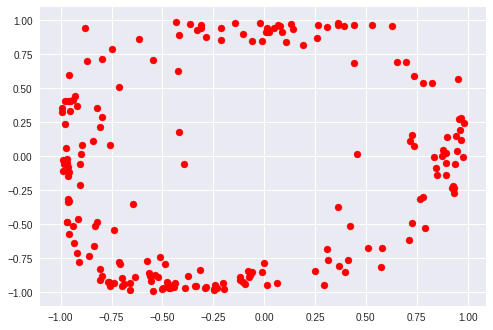

Epoch: [440/1000]
Discriminator Loss: 1.3352, Generator Loss: 0.8253
D(x): 0.5167, D(G(z)): 0.4492
Epoch: [441/1000]
Discriminator Loss: 1.4236, Generator Loss: 0.6876
D(x): 0.5568, D(G(z)): 0.5246
Epoch: [442/1000]
Discriminator Loss: 1.3879, Generator Loss: 0.7985
D(x): 0.5164, D(G(z)): 0.5011
Epoch: [443/1000]
Discriminator Loss: 1.4171, Generator Loss: 0.6941
D(x): 0.5404, D(G(z)): 0.5458
Epoch: [444/1000]
Discriminator Loss: 1.2367, Generator Loss: 0.8527
D(x): 0.5414, D(G(z)): 0.4511
Epoch: [445/1000]
Discriminator Loss: 1.1893, Generator Loss: 0.9096
D(x): 0.5638, D(G(z)): 0.4263
Epoch: [446/1000]
Discriminator Loss: 1.4557, Generator Loss: 0.6563
D(x): 0.5338, D(G(z)): 0.5392
Epoch: [447/1000]
Discriminator Loss: 1.3554, Generator Loss: 0.7866
D(x): 0.5217, D(G(z)): 0.4868
Epoch: [448/1000]
Discriminator Loss: 1.3273, Generator Loss: 0.7552
D(x): 0.5127, D(G(z)): 0.4619
Epoch: [449/1000]
Discriminator Loss: 1.3501, Generator Loss: 0.7171
D(x): 0.5202, D(G(z)): 0.4909


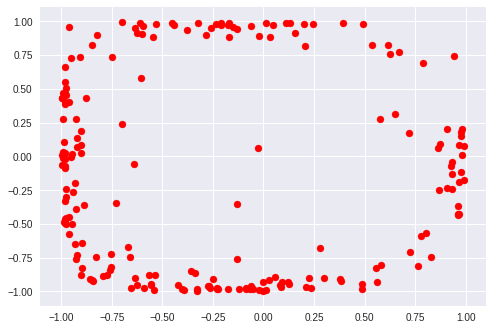

Epoch: [450/1000]
Discriminator Loss: 1.3272, Generator Loss: 0.7425
D(x): 0.5323, D(G(z)): 0.4905
Epoch: [451/1000]
Discriminator Loss: 1.3301, Generator Loss: 0.7449
D(x): 0.5466, D(G(z)): 0.5004
Epoch: [452/1000]
Discriminator Loss: 1.4000, Generator Loss: 0.7734
D(x): 0.5067, D(G(z)): 0.4964
Epoch: [453/1000]
Discriminator Loss: 1.3987, Generator Loss: 0.7268
D(x): 0.4853, D(G(z)): 0.4797
Epoch: [454/1000]
Discriminator Loss: 1.3582, Generator Loss: 0.6811
D(x): 0.5181, D(G(z)): 0.4979
Epoch: [455/1000]
Discriminator Loss: 1.3592, Generator Loss: 0.7431
D(x): 0.5229, D(G(z)): 0.4924
Epoch: [456/1000]
Discriminator Loss: 1.3468, Generator Loss: 0.9481
D(x): 0.5216, D(G(z)): 0.4656
Epoch: [457/1000]
Discriminator Loss: 1.3343, Generator Loss: 0.8555
D(x): 0.5216, D(G(z)): 0.4691
Epoch: [458/1000]
Discriminator Loss: 1.3416, Generator Loss: 0.8494
D(x): 0.5117, D(G(z)): 0.4547
Epoch: [459/1000]
Discriminator Loss: 1.4040, Generator Loss: 0.8259
D(x): 0.4929, D(G(z)): 0.4581


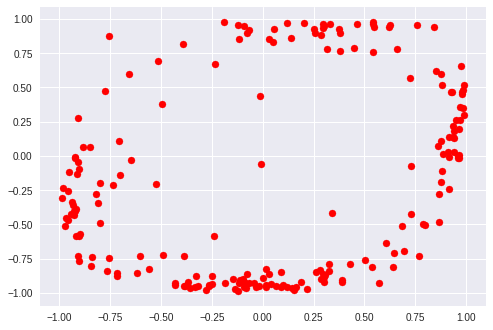

Epoch: [460/1000]
Discriminator Loss: 1.4066, Generator Loss: 0.7803
D(x): 0.5131, D(G(z)): 0.4807
Epoch: [461/1000]
Discriminator Loss: 1.3706, Generator Loss: 0.8312
D(x): 0.5302, D(G(z)): 0.4958
Epoch: [462/1000]
Discriminator Loss: 1.2766, Generator Loss: 0.7238
D(x): 0.5603, D(G(z)): 0.4895
Epoch: [463/1000]
Discriminator Loss: 1.1699, Generator Loss: 0.8540
D(x): 0.5584, D(G(z)): 0.4264
Epoch: [464/1000]
Discriminator Loss: 1.3242, Generator Loss: 0.8243
D(x): 0.5454, D(G(z)): 0.4796
Epoch: [465/1000]
Discriminator Loss: 1.3894, Generator Loss: 0.7048
D(x): 0.5157, D(G(z)): 0.4975
Epoch: [466/1000]
Discriminator Loss: 1.3705, Generator Loss: 0.7422
D(x): 0.5010, D(G(z)): 0.4840
Epoch: [467/1000]
Discriminator Loss: 1.3176, Generator Loss: 0.6523
D(x): 0.5473, D(G(z)): 0.5053
Epoch: [468/1000]
Discriminator Loss: 1.2827, Generator Loss: 0.7937
D(x): 0.5303, D(G(z)): 0.4435
Epoch: [469/1000]
Discriminator Loss: 1.3735, Generator Loss: 0.8457
D(x): 0.5251, D(G(z)): 0.4981


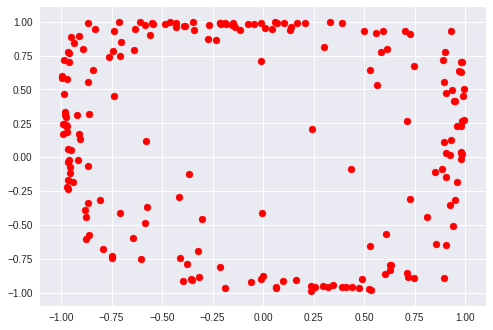

Epoch: [470/1000]
Discriminator Loss: 1.4115, Generator Loss: 0.8089
D(x): 0.5274, D(G(z)): 0.5127
Epoch: [471/1000]
Discriminator Loss: 1.2649, Generator Loss: 1.1419
D(x): 0.5436, D(G(z)): 0.4403
Epoch: [472/1000]
Discriminator Loss: 1.4514, Generator Loss: 0.7097
D(x): 0.4969, D(G(z)): 0.5066
Epoch: [473/1000]
Discriminator Loss: 1.3173, Generator Loss: 0.7047
D(x): 0.5328, D(G(z)): 0.4842
Epoch: [474/1000]
Discriminator Loss: 1.3419, Generator Loss: 0.7959
D(x): 0.4990, D(G(z)): 0.4676
Epoch: [475/1000]
Discriminator Loss: 1.3167, Generator Loss: 0.8917
D(x): 0.5110, D(G(z)): 0.4590
Epoch: [476/1000]
Discriminator Loss: 1.1846, Generator Loss: 1.2003
D(x): 0.5494, D(G(z)): 0.3880
Epoch: [477/1000]
Discriminator Loss: 1.2647, Generator Loss: 0.9046
D(x): 0.5728, D(G(z)): 0.4711
Epoch: [478/1000]
Discriminator Loss: 1.1819, Generator Loss: 0.8823
D(x): 0.5970, D(G(z)): 0.4613
Epoch: [479/1000]
Discriminator Loss: 1.3735, Generator Loss: 0.7735
D(x): 0.5290, D(G(z)): 0.4781


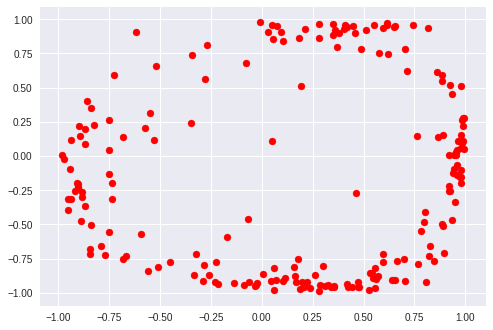

Epoch: [480/1000]
Discriminator Loss: 1.3087, Generator Loss: 0.8434
D(x): 0.4964, D(G(z)): 0.4189
Epoch: [481/1000]
Discriminator Loss: 1.3768, Generator Loss: 0.7868
D(x): 0.5210, D(G(z)): 0.4891
Epoch: [482/1000]
Discriminator Loss: 1.2528, Generator Loss: 0.9490
D(x): 0.5123, D(G(z)): 0.4260
Epoch: [483/1000]
Discriminator Loss: 1.3738, Generator Loss: 0.8176
D(x): 0.5428, D(G(z)): 0.5189
Epoch: [484/1000]
Discriminator Loss: 1.3180, Generator Loss: 0.7559
D(x): 0.5191, D(G(z)): 0.4611
Epoch: [485/1000]
Discriminator Loss: 1.3098, Generator Loss: 0.7128
D(x): 0.5096, D(G(z)): 0.4454
Epoch: [486/1000]
Discriminator Loss: 1.2538, Generator Loss: 0.8363
D(x): 0.5652, D(G(z)): 0.4659
Epoch: [487/1000]
Discriminator Loss: 1.3281, Generator Loss: 0.7695
D(x): 0.4919, D(G(z)): 0.4299
Epoch: [488/1000]
Discriminator Loss: 1.4748, Generator Loss: 0.8448
D(x): 0.5003, D(G(z)): 0.5111
Epoch: [489/1000]
Discriminator Loss: 1.3279, Generator Loss: 0.6248
D(x): 0.5545, D(G(z)): 0.5120


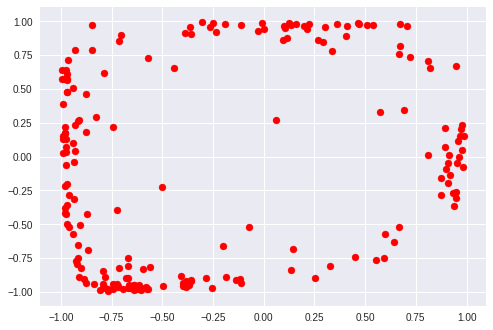

Epoch: [490/1000]
Discriminator Loss: 1.3703, Generator Loss: 0.7496
D(x): 0.5043, D(G(z)): 0.4823
Epoch: [491/1000]
Discriminator Loss: 1.3692, Generator Loss: 0.7751
D(x): 0.5288, D(G(z)): 0.5070
Epoch: [492/1000]
Discriminator Loss: 1.3355, Generator Loss: 0.8192
D(x): 0.5332, D(G(z)): 0.4889
Epoch: [493/1000]
Discriminator Loss: 1.4576, Generator Loss: 0.8907
D(x): 0.4862, D(G(z)): 0.5078
Epoch: [494/1000]
Discriminator Loss: 1.3727, Generator Loss: 0.8156
D(x): 0.5162, D(G(z)): 0.4876
Epoch: [495/1000]
Discriminator Loss: 1.3787, Generator Loss: 0.7207
D(x): 0.5227, D(G(z)): 0.4911
Epoch: [496/1000]
Discriminator Loss: 1.3240, Generator Loss: 0.8216
D(x): 0.4870, D(G(z)): 0.4152
Epoch: [497/1000]
Discriminator Loss: 1.2991, Generator Loss: 0.7234
D(x): 0.5634, D(G(z)): 0.5017
Epoch: [498/1000]
Discriminator Loss: 1.3354, Generator Loss: 1.0096
D(x): 0.4870, D(G(z)): 0.4378
Epoch: [499/1000]
Discriminator Loss: 1.3631, Generator Loss: 0.7825
D(x): 0.4915, D(G(z)): 0.4439


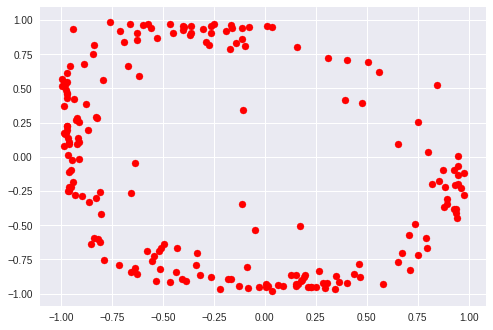

Epoch: [500/1000]
Discriminator Loss: 1.1800, Generator Loss: 0.8630
D(x): 0.5216, D(G(z)): 0.3522
Epoch: [501/1000]
Discriminator Loss: 1.3081, Generator Loss: 0.7593
D(x): 0.5410, D(G(z)): 0.4561
Epoch: [502/1000]
Discriminator Loss: 1.3253, Generator Loss: 0.7443
D(x): 0.5739, D(G(z)): 0.5036
Epoch: [503/1000]
Discriminator Loss: 1.2565, Generator Loss: 0.9134
D(x): 0.5065, D(G(z)): 0.3741
Epoch: [504/1000]
Discriminator Loss: 1.4981, Generator Loss: 0.7385
D(x): 0.4963, D(G(z)): 0.5185
Epoch: [505/1000]
Discriminator Loss: 1.3052, Generator Loss: 0.7906
D(x): 0.5391, D(G(z)): 0.4777
Epoch: [506/1000]
Discriminator Loss: 1.2766, Generator Loss: 0.7032
D(x): 0.5576, D(G(z)): 0.4785
Epoch: [507/1000]
Discriminator Loss: 1.3341, Generator Loss: 0.7125
D(x): 0.5272, D(G(z)): 0.4918
Epoch: [508/1000]
Discriminator Loss: 1.3659, Generator Loss: 0.7193
D(x): 0.4770, D(G(z)): 0.4574
Epoch: [509/1000]
Discriminator Loss: 1.3997, Generator Loss: 0.8440
D(x): 0.5267, D(G(z)): 0.5161


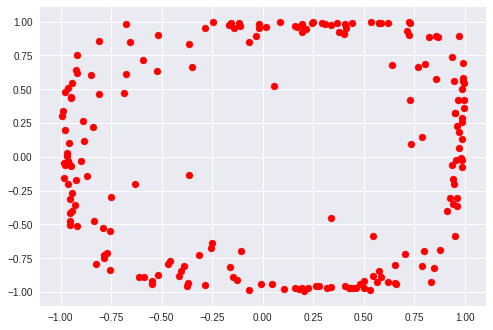

Epoch: [510/1000]
Discriminator Loss: 1.3088, Generator Loss: 0.7349
D(x): 0.5439, D(G(z)): 0.4906
Epoch: [511/1000]
Discriminator Loss: 1.3151, Generator Loss: 0.7853
D(x): 0.5119, D(G(z)): 0.4629
Epoch: [512/1000]
Discriminator Loss: 1.3358, Generator Loss: 0.6938
D(x): 0.5139, D(G(z)): 0.4731
Epoch: [513/1000]
Discriminator Loss: 1.3432, Generator Loss: 0.7197
D(x): 0.5191, D(G(z)): 0.4876
Epoch: [514/1000]
Discriminator Loss: 1.3209, Generator Loss: 0.6721
D(x): 0.5521, D(G(z)): 0.5080
Epoch: [515/1000]
Discriminator Loss: 1.3902, Generator Loss: 0.7630
D(x): 0.4938, D(G(z)): 0.4834
Epoch: [516/1000]
Discriminator Loss: 1.3934, Generator Loss: 0.9243
D(x): 0.4968, D(G(z)): 0.4684
Epoch: [517/1000]
Discriminator Loss: 1.4006, Generator Loss: 0.7687
D(x): 0.5305, D(G(z)): 0.5066
Epoch: [518/1000]
Discriminator Loss: 1.3292, Generator Loss: 0.6750
D(x): 0.5292, D(G(z)): 0.4793
Epoch: [519/1000]
Discriminator Loss: 1.3950, Generator Loss: 0.8703
D(x): 0.5035, D(G(z)): 0.4689


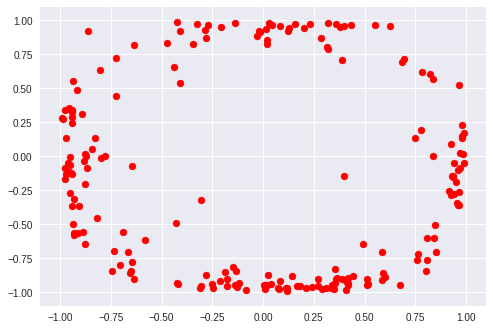

Epoch: [520/1000]
Discriminator Loss: 1.3032, Generator Loss: 0.6992
D(x): 0.5347, D(G(z)): 0.4742
Epoch: [521/1000]
Discriminator Loss: 1.3814, Generator Loss: 0.6907
D(x): 0.5377, D(G(z)): 0.5216
Epoch: [522/1000]
Discriminator Loss: 1.3373, Generator Loss: 0.7930
D(x): 0.4965, D(G(z)): 0.4538
Epoch: [523/1000]
Discriminator Loss: 1.3332, Generator Loss: 0.7551
D(x): 0.5380, D(G(z)): 0.4948
Epoch: [524/1000]
Discriminator Loss: 1.4524, Generator Loss: 0.7118
D(x): 0.4898, D(G(z)): 0.4866
Epoch: [525/1000]
Discriminator Loss: 1.4241, Generator Loss: 0.7304
D(x): 0.4981, D(G(z)): 0.4860
Epoch: [526/1000]
Discriminator Loss: 1.3087, Generator Loss: 0.7670
D(x): 0.5307, D(G(z)): 0.4737
Epoch: [527/1000]
Discriminator Loss: 1.4244, Generator Loss: 0.9184
D(x): 0.4880, D(G(z)): 0.4798
Epoch: [528/1000]
Discriminator Loss: 1.3295, Generator Loss: 0.6686
D(x): 0.5552, D(G(z)): 0.5038
Epoch: [529/1000]
Discriminator Loss: 1.4353, Generator Loss: 0.6791
D(x): 0.4902, D(G(z)): 0.4948


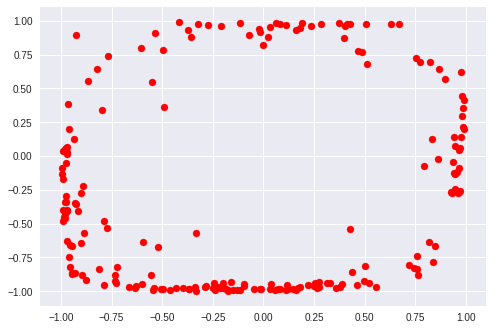

Epoch: [530/1000]
Discriminator Loss: 1.3010, Generator Loss: 0.7412
D(x): 0.5342, D(G(z)): 0.4757
Epoch: [531/1000]
Discriminator Loss: 1.3234, Generator Loss: 0.7455
D(x): 0.5228, D(G(z)): 0.4786
Epoch: [532/1000]
Discriminator Loss: 1.4164, Generator Loss: 0.8627
D(x): 0.5242, D(G(z)): 0.5273
Epoch: [533/1000]
Discriminator Loss: 1.3692, Generator Loss: 0.8467
D(x): 0.5168, D(G(z)): 0.4947
Epoch: [534/1000]
Discriminator Loss: 1.3942, Generator Loss: 0.7155
D(x): 0.5198, D(G(z)): 0.4947
Epoch: [535/1000]
Discriminator Loss: 1.3443, Generator Loss: 0.6714
D(x): 0.5124, D(G(z)): 0.4831
Epoch: [536/1000]
Discriminator Loss: 1.4007, Generator Loss: 0.7214
D(x): 0.5073, D(G(z)): 0.5032
Epoch: [537/1000]
Discriminator Loss: 1.3730, Generator Loss: 0.7818
D(x): 0.5199, D(G(z)): 0.4990
Epoch: [538/1000]
Discriminator Loss: 1.2844, Generator Loss: 0.8029
D(x): 0.5223, D(G(z)): 0.4582
Epoch: [539/1000]
Discriminator Loss: 1.3492, Generator Loss: 0.7734
D(x): 0.5060, D(G(z)): 0.4627


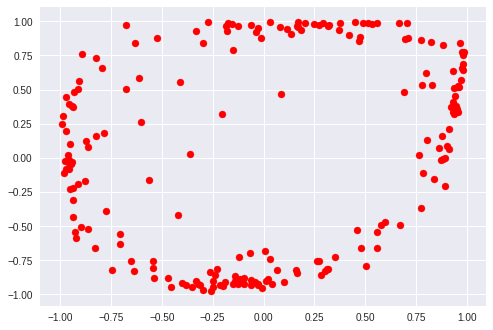

Epoch: [540/1000]
Discriminator Loss: 1.3261, Generator Loss: 0.7793
D(x): 0.5268, D(G(z)): 0.4705
Epoch: [541/1000]
Discriminator Loss: 1.3262, Generator Loss: 0.7885
D(x): 0.5362, D(G(z)): 0.4729
Epoch: [542/1000]
Discriminator Loss: 1.4068, Generator Loss: 0.8772
D(x): 0.4805, D(G(z)): 0.4490
Epoch: [543/1000]
Discriminator Loss: 1.2365, Generator Loss: 0.7829
D(x): 0.6010, D(G(z)): 0.4996
Epoch: [544/1000]
Discriminator Loss: 1.4206, Generator Loss: 0.8836
D(x): 0.4975, D(G(z)): 0.4568
Epoch: [545/1000]
Discriminator Loss: 1.3142, Generator Loss: 0.6019
D(x): 0.5488, D(G(z)): 0.4759
Epoch: [546/1000]
Discriminator Loss: 1.3279, Generator Loss: 0.7633
D(x): 0.5563, D(G(z)): 0.5044
Epoch: [547/1000]
Discriminator Loss: 1.3765, Generator Loss: 0.7428
D(x): 0.4772, D(G(z)): 0.4621
Epoch: [548/1000]
Discriminator Loss: 1.3553, Generator Loss: 0.7774
D(x): 0.5213, D(G(z)): 0.4977
Epoch: [549/1000]
Discriminator Loss: 1.3192, Generator Loss: 0.7505
D(x): 0.5285, D(G(z)): 0.4773


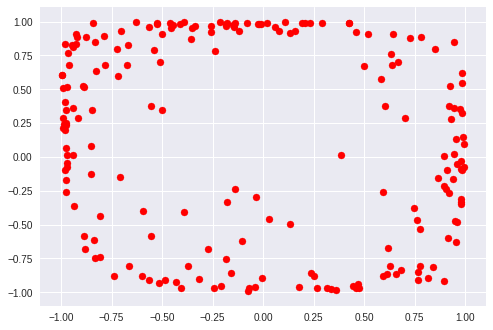

Epoch: [550/1000]
Discriminator Loss: 1.2649, Generator Loss: 0.7472
D(x): 0.5634, D(G(z)): 0.4681
Epoch: [551/1000]
Discriminator Loss: 1.2951, Generator Loss: 0.7834
D(x): 0.5486, D(G(z)): 0.4879
Epoch: [552/1000]
Discriminator Loss: 1.3868, Generator Loss: 0.7105
D(x): 0.5113, D(G(z)): 0.4972
Epoch: [553/1000]
Discriminator Loss: 1.2546, Generator Loss: 0.6846
D(x): 0.5302, D(G(z)): 0.4456
Epoch: [554/1000]
Discriminator Loss: 1.3203, Generator Loss: 0.7663
D(x): 0.5079, D(G(z)): 0.4642
Epoch: [555/1000]
Discriminator Loss: 1.3002, Generator Loss: 0.6852
D(x): 0.5433, D(G(z)): 0.4865
Epoch: [556/1000]
Discriminator Loss: 1.2683, Generator Loss: 0.8878
D(x): 0.5091, D(G(z)): 0.4259
Epoch: [557/1000]
Discriminator Loss: 1.2774, Generator Loss: 1.0589
D(x): 0.5568, D(G(z)): 0.4655
Epoch: [558/1000]
Discriminator Loss: 1.2493, Generator Loss: 0.8871
D(x): 0.5011, D(G(z)): 0.3909
Epoch: [559/1000]
Discriminator Loss: 1.2827, Generator Loss: 0.6503
D(x): 0.5664, D(G(z)): 0.4725


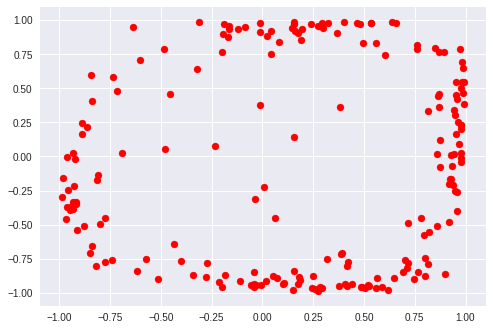

Epoch: [560/1000]
Discriminator Loss: 1.3212, Generator Loss: 0.8676
D(x): 0.5521, D(G(z)): 0.4950
Epoch: [561/1000]
Discriminator Loss: 1.3516, Generator Loss: 0.7752
D(x): 0.5271, D(G(z)): 0.4578
Epoch: [562/1000]
Discriminator Loss: 1.2895, Generator Loss: 0.7093
D(x): 0.5293, D(G(z)): 0.4605
Epoch: [563/1000]
Discriminator Loss: 1.3615, Generator Loss: 0.7438
D(x): 0.5927, D(G(z)): 0.5549
Epoch: [564/1000]
Discriminator Loss: 1.3797, Generator Loss: 0.7343
D(x): 0.4988, D(G(z)): 0.4837
Epoch: [565/1000]
Discriminator Loss: 1.4359, Generator Loss: 0.8481
D(x): 0.4545, D(G(z)): 0.4535
Epoch: [566/1000]
Discriminator Loss: 1.3534, Generator Loss: 0.7057
D(x): 0.5425, D(G(z)): 0.4969
Epoch: [567/1000]
Discriminator Loss: 1.2065, Generator Loss: 0.9389
D(x): 0.5494, D(G(z)): 0.4173
Epoch: [568/1000]
Discriminator Loss: 1.3799, Generator Loss: 0.9781
D(x): 0.5406, D(G(z)): 0.5061
Epoch: [569/1000]
Discriminator Loss: 1.3543, Generator Loss: 0.8997
D(x): 0.4834, D(G(z)): 0.4334


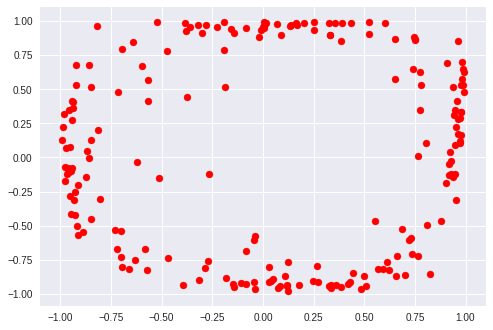

Epoch: [570/1000]
Discriminator Loss: 1.3675, Generator Loss: 0.7310
D(x): 0.5304, D(G(z)): 0.4848
Epoch: [571/1000]
Discriminator Loss: 1.4237, Generator Loss: 0.7775
D(x): 0.4817, D(G(z)): 0.4707
Epoch: [572/1000]
Discriminator Loss: 1.3199, Generator Loss: 0.7722
D(x): 0.5328, D(G(z)): 0.4828
Epoch: [573/1000]
Discriminator Loss: 1.3129, Generator Loss: 0.8676
D(x): 0.5582, D(G(z)): 0.4925
Epoch: [574/1000]
Discriminator Loss: 1.4196, Generator Loss: 1.0426
D(x): 0.5140, D(G(z)): 0.4859
Epoch: [575/1000]
Discriminator Loss: 1.4966, Generator Loss: 0.7569
D(x): 0.5399, D(G(z)): 0.5591
Epoch: [576/1000]
Discriminator Loss: 1.4303, Generator Loss: 0.8409
D(x): 0.4535, D(G(z)): 0.4585
Epoch: [577/1000]
Discriminator Loss: 1.3365, Generator Loss: 0.7370
D(x): 0.5265, D(G(z)): 0.4845
Epoch: [578/1000]
Discriminator Loss: 1.0700, Generator Loss: 0.8989
D(x): 0.5881, D(G(z)): 0.3737
Epoch: [579/1000]
Discriminator Loss: 1.2048, Generator Loss: 0.8535
D(x): 0.5974, D(G(z)): 0.4569


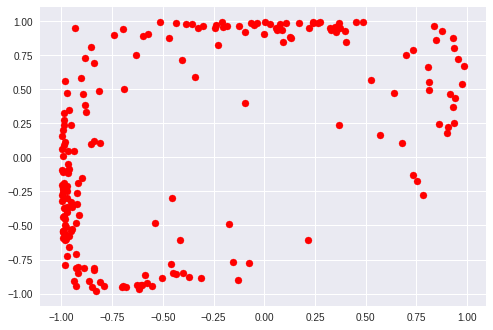

Epoch: [580/1000]
Discriminator Loss: 1.1679, Generator Loss: 0.9940
D(x): 0.5833, D(G(z)): 0.3861
Epoch: [581/1000]
Discriminator Loss: 1.2345, Generator Loss: 1.0866
D(x): 0.5659, D(G(z)): 0.4354
Epoch: [582/1000]
Discriminator Loss: 1.2211, Generator Loss: 0.9774
D(x): 0.5207, D(G(z)): 0.3814
Epoch: [583/1000]
Discriminator Loss: 1.2116, Generator Loss: 0.8711
D(x): 0.5878, D(G(z)): 0.4548
Epoch: [584/1000]
Discriminator Loss: 1.3041, Generator Loss: 0.9811
D(x): 0.5353, D(G(z)): 0.4295
Epoch: [585/1000]
Discriminator Loss: 1.3489, Generator Loss: 0.7969
D(x): 0.5266, D(G(z)): 0.4677
Epoch: [586/1000]
Discriminator Loss: 1.4620, Generator Loss: 0.7777
D(x): 0.4876, D(G(z)): 0.5021
Epoch: [587/1000]
Discriminator Loss: 1.3198, Generator Loss: 0.7944
D(x): 0.5154, D(G(z)): 0.4665
Epoch: [588/1000]
Discriminator Loss: 1.3429, Generator Loss: 0.7839
D(x): 0.5363, D(G(z)): 0.4981
Epoch: [589/1000]
Discriminator Loss: 1.4652, Generator Loss: 0.8488
D(x): 0.5170, D(G(z)): 0.5328


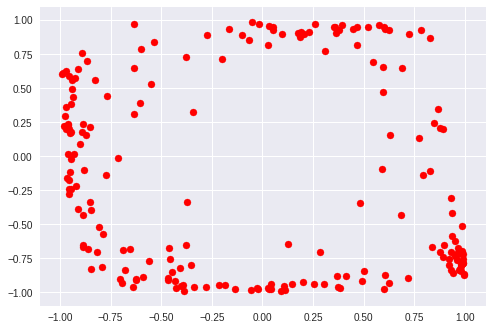

Epoch: [590/1000]
Discriminator Loss: 1.3359, Generator Loss: 0.8228
D(x): 0.5301, D(G(z)): 0.4931
Epoch: [591/1000]
Discriminator Loss: 1.3847, Generator Loss: 0.6599
D(x): 0.5272, D(G(z)): 0.5132
Epoch: [592/1000]
Discriminator Loss: 1.3161, Generator Loss: 0.8890
D(x): 0.5274, D(G(z)): 0.4783
Epoch: [593/1000]
Discriminator Loss: 1.3086, Generator Loss: 0.7297
D(x): 0.5243, D(G(z)): 0.4420
Epoch: [594/1000]
Discriminator Loss: 1.4059, Generator Loss: 0.7982
D(x): 0.5194, D(G(z)): 0.5035
Epoch: [595/1000]
Discriminator Loss: 1.3168, Generator Loss: 0.7521
D(x): 0.5131, D(G(z)): 0.4630
Epoch: [596/1000]
Discriminator Loss: 1.3985, Generator Loss: 0.8093
D(x): 0.4946, D(G(z)): 0.4814
Epoch: [597/1000]
Discriminator Loss: 1.3928, Generator Loss: 0.8252
D(x): 0.5177, D(G(z)): 0.4961
Epoch: [598/1000]
Discriminator Loss: 1.2609, Generator Loss: 1.0331
D(x): 0.4857, D(G(z)): 0.3871
Epoch: [599/1000]
Discriminator Loss: 1.2733, Generator Loss: 0.6774
D(x): 0.5353, D(G(z)): 0.4362


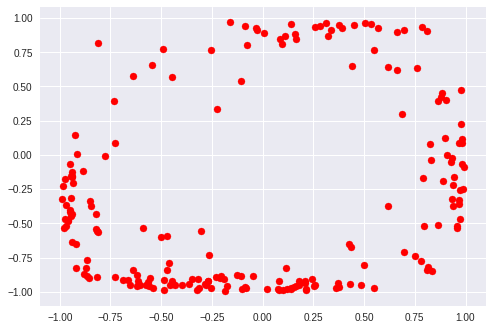

Epoch: [600/1000]
Discriminator Loss: 1.2329, Generator Loss: 0.8475
D(x): 0.5183, D(G(z)): 0.4033
Epoch: [601/1000]
Discriminator Loss: 1.3581, Generator Loss: 0.8017
D(x): 0.5131, D(G(z)): 0.4547
Epoch: [602/1000]
Discriminator Loss: 1.2415, Generator Loss: 0.7905
D(x): 0.5644, D(G(z)): 0.4599
Epoch: [603/1000]
Discriminator Loss: 1.3337, Generator Loss: 0.7530
D(x): 0.5683, D(G(z)): 0.4941
Epoch: [604/1000]
Discriminator Loss: 1.3047, Generator Loss: 0.7707
D(x): 0.5225, D(G(z)): 0.4603
Epoch: [605/1000]
Discriminator Loss: 1.3367, Generator Loss: 0.6879
D(x): 0.5420, D(G(z)): 0.5022
Epoch: [606/1000]
Discriminator Loss: 1.3999, Generator Loss: 0.7444
D(x): 0.4959, D(G(z)): 0.4866
Epoch: [607/1000]
Discriminator Loss: 1.3886, Generator Loss: 0.7536
D(x): 0.5261, D(G(z)): 0.5173
Epoch: [608/1000]
Discriminator Loss: 1.3286, Generator Loss: 0.6991
D(x): 0.5135, D(G(z)): 0.4729


KeyboardInterrupt: ignored

In [0]:
gan_magic(generator, discriminator, circle_data_loader, circle_noise,
          plot_circle, epochs=1000, disc_steps=10, test_samples=200, draw_every_n=10, d_lr=0.01, g_lr=0.01)

# DCGAN

In [0]:
LATENT_SIZE = 100
GEN_FEATS = 32
DIS_FEATS = 32
NUM_CHANNELS = 1
IMAGE_W = 28
IMAGE_H = 28
BATCH_SIZE = 32
TEST_SAMPLES = 16

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([.5], [.5])
        ])
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
# Num batches
num_batches = len(data_loader)

0it [00:00, ?it/s]

26427392it [00:01, 13720764.84it/s]                             


Extracting ./dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 99557.66it/s]            
0it [00:00, ?it/s]

Extracting ./dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 4345474.38it/s]                             
0it [00:00, ?it/s]

Extracting ./dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 34773.37it/s]            

Extracting ./dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
def plot_images(images):
    images = images.numpy().reshape(images.shape[0], 28, 28)
    
    images_row = 6
    num_images = len(images)

    
    f, axarr = plt.subplots((num_images // images_row) + 1, 
                            images_row)
  
    for ax in axarr.flatten():
      ax.axis('off')
  
    for i, image in enumerate(images):
      ax = axarr[i // images_row, i % images_row]
      ax.imshow(image)
    clear_output()
    plt.show()

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        nc = 1
        ndf = 64
 
        self.conv1 = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(NUM_CHANNELS, DIS_FEATS, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            # state size. (ndf) x 14 x 14
            nn.Conv2d(DIS_FEATS, DIS_FEATS*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(DIS_FEATS*2),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(DIS_FEATS*2, DIS_FEATS*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(DIS_FEATS*4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.linear1 = nn.Sequential(   
            # state size. (ndf*4) x 4 x 4
            nn.Linear(DIS_FEATS*4 * 4 * 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, DIS_FEATS*4*4*4)
        x = self.linear1(x)
        return x

discriminator = to_gpu(DiscriminatorNet())
discriminator.apply(weights_init)

DiscriminatorNet(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (linear1): Sequential(
    (0): Linear(in_features=2048, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [0]:

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
       
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(LATENT_SIZE, GEN_FEATS*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(GEN_FEATS*4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(GEN_FEATS*4, GEN_FEATS*2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATS*2),
            nn.ReLU(True),
            # state size. (ngf*4) x 7 x 7
            nn.ConvTranspose2d(GEN_FEATS*2,GEN_FEATS, 4, 2, 1, bias=False),
            nn.BatchNorm2d(GEN_FEATS),
            nn.ReLU(True),
            # state size. (ngf*2) x 14 x 14
            nn.ConvTranspose2d(GEN_FEATS, NUM_CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (NUM_CHANNELS x 28 x 28)
        )

    def forward(self, x):
        x = self.main(x)
        return x

generator = to_gpu(GeneratorNet())
generator.apply(weights_init)

GeneratorNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, LATENT_SIZE, 1, 1))
    return to_gpu(n)
  

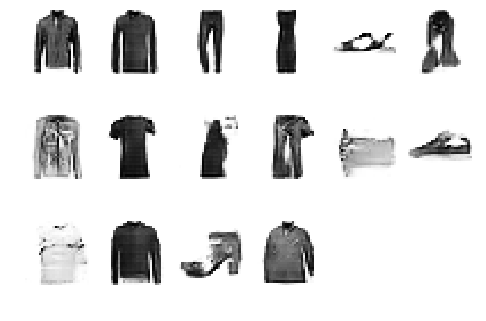

Epoch: [17/100]
Discriminator Loss: 0.5677, Generator Loss: 3.9428
D(x): 0.6321, D(G(z)): 0.0338


In [0]:
gan_magic(generator, discriminator, data_loader, noise, plot_images, test_samples=TEST_SAMPLES,
          disc_steps=1, d_lr=0.0001, g_lr=0.0001)